In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting transit times

Fitting for or marginalizing over the transit times or transit timing variations (TTVs) can be useful for several reasons, and it is a compelling use case for `exoplanet` becuase the number of parameters in the model increases significantly because there will be a new parameter for each transit.
The performance of the NUTS sampler used by `exoplanet` scales well with the number of parameters, so a TTV model should be substantially faster to run to convergence with `exoplanet` than with other tools.
There are a few definitions and subtleties that should be considered before jumping in.

In this tutorial, we will be using a "descriptive" model :class:`orbits.TTVOrbit` to fit the light curve where the underlying motion is still Keplerian, but the time coordinate is warped to make `t0` a function of time.
All of the other orbital elements besides `t0` are shared across all orbits, but the `t0` for each transit will be a parameter.
This means that other variations (like transit duration variations) are not currently supported, but it would be possible to include more general effects.
`exoplanet` also supports photodynamics modeling using the :class:`orbits.ReboundOrbit` for more detailed analysis, but that is a topic for a future tutorial.

It is also important to note that "transit time" within `exoplanet` (and most other transit fitting software) is defined as the time of conjunction (called `t0` in the code): the time when the true anomaly is $\pi/2 - \omega$.
Section 18 of [the EXOFASTv2 paper](https://arxiv.org/abs/1907.09480) includes an excellent discussion of some of the commonly used definitions of "transit time" in the literature.

Finally, there is a subtlety in the definition of the "period" of an orbit with TTVs.
Two possible definitions are: (1) the average time between transits, or (2) the slope of a least squares fit to the transit times as a function of transit number.
In `exoplanet`, we use the latter definition and call this parameter the `ttv_period` to distinguish it from the `period` of the underlying Keplerian motion which sets the shape and duration of the transit.
By default, these two periods are constrained to be equal, but it can be useful to fit for both parameters since the shape of the transit might not be perfectly described by the same period.
That being said, if you fit for both periods, make sure that you constrain `ttv_period` and `period` to be similar or things can get a bit ugly.

To get started, let's generate some simulated transit times.
We'll use the :func:`orbits.ttv.compute_expected_transit_times` function to get the expected transit times for a linear ephemeris within some observation baseline:

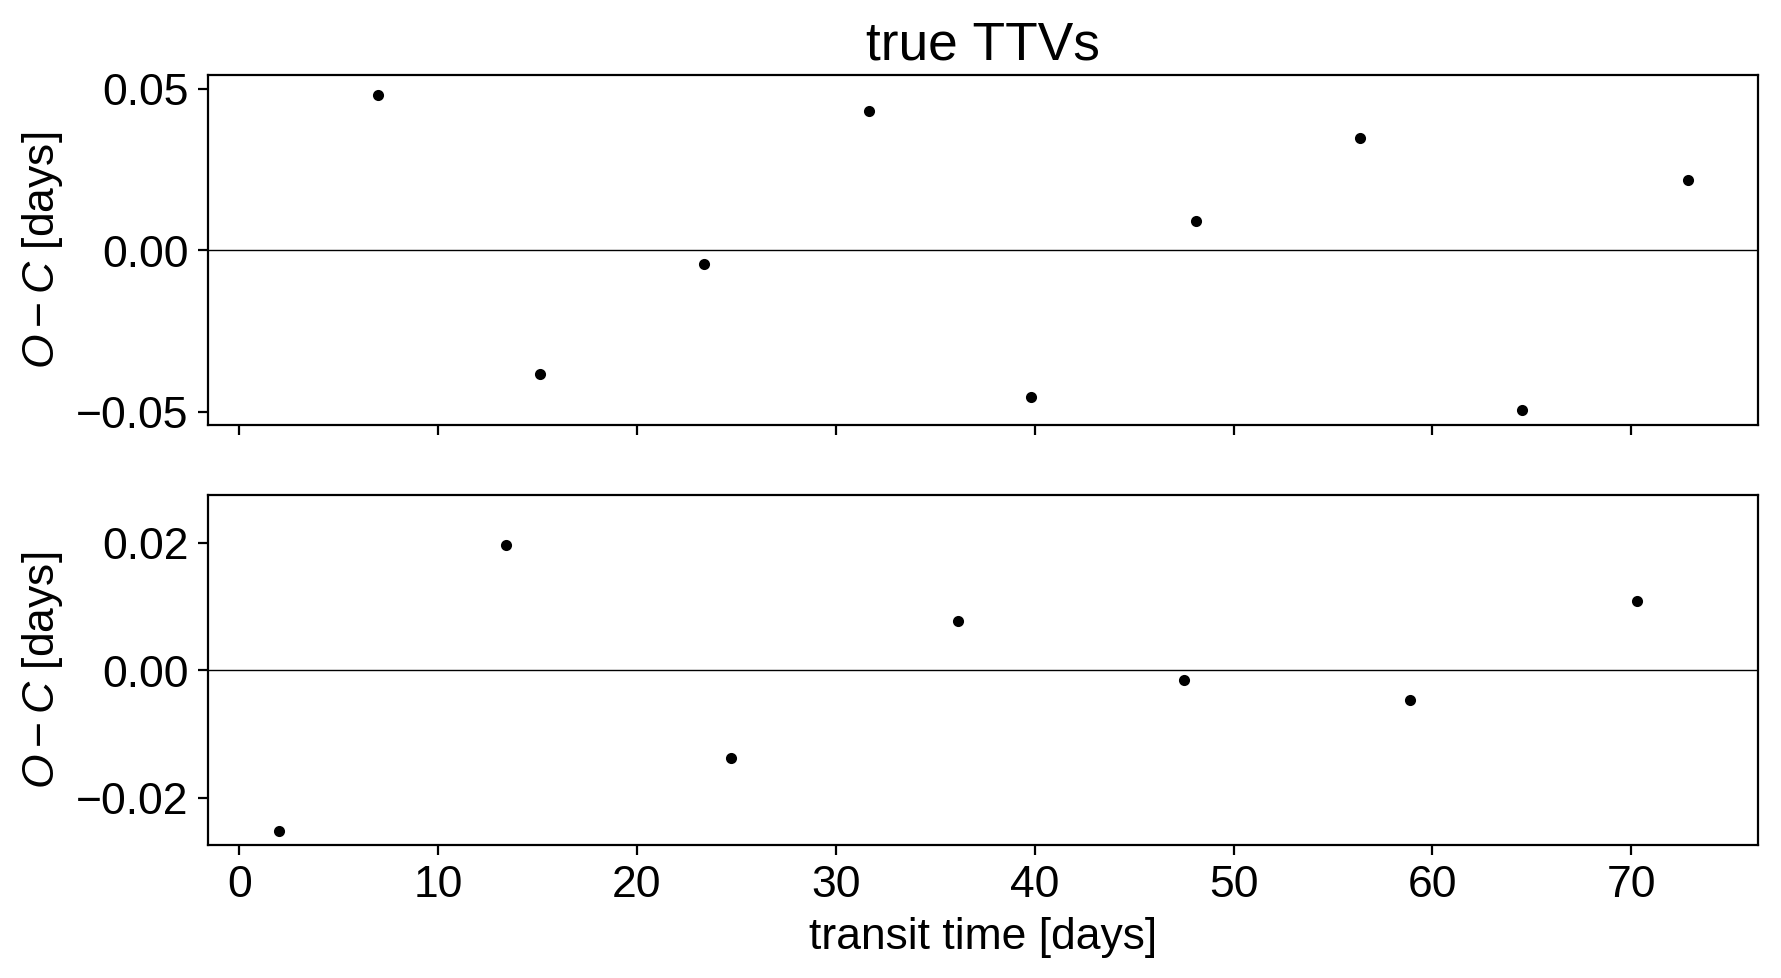

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(3948)
true_periods = np.random.uniform(8, 12, 2)
true_t0s = true_periods * np.random.rand(2)
t = np.arange(0, 80, 0.01)
texp = 0.01
yerr = 5e-4

# Compute the transit times for a linear ephemeris
true_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    t.min(), t.max(), true_periods, true_t0s
)

# Simulate transit timing variations using a simple model
true_ttvs = [
    (0.05 - (i % 2) * 0.1) * np.sin(2 * np.pi * tt / 23.7)
    for i, tt in enumerate(true_transit_times)
]
true_transit_times = [tt + v for tt, v in zip(true_transit_times, true_ttvs)]

# Plot the true TTV model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(true_transit_times[0], true_ttvs[0], ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))
ax1.set_ylabel("$O-C$ [days]")

ax2.plot(true_transit_times[1], true_ttvs[1], ".k")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))
ax2.set_ylabel("$O-C$ [days]")

ax2.set_xlabel("transit time [days]")
ax1.set_title("true TTVs");

Now, like in the :ref:`transit` tutorial, we'll set up the the model using `PyMC3` and `exoplanet`, and then simulate a data set from that model.

In [4]:
import pymc3 as pm
import theano.tensor as tt

np.random.seed(9485023)

with pm.Model() as model:

    # This part of the model is similar to the model in the `transit` tutorial
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    logr = pm.Uniform(
        "logr",
        lower=np.log(0.01),
        upper=np.log(0.1),
        shape=2,
        testval=np.log([0.04, 0.06]),
    )
    r = pm.Deterministic("r", tt.exp(logr))
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=0.5 * np.random.rand(2)
    )

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(2):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=true_transit_times[i],
                sd=1.0,
                shape=len(true_transit_times[i]),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(2):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t, texp=texp
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    map_soln = model.test_point
    map_soln = xo.optimize(start=map_soln, vars=transit_times)
    map_soln = xo.optimize(start=map_soln, vars=[r, b])
    map_soln = xo.optimize(start=map_soln, vars=transit_times)
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [tts_1, tts_0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.945488e+04]

1it [00:00, 81.77it/s, logp=4.945488e+04]

2it [00:00, 120.98it/s, logp=4.945488e+04]

3it [00:00, 139.58it/s, logp=4.317367e+04]

4it [00:00, 157.43it/s, logp=4.919676e+04]

5it [00:00, 171.38it/s, logp=4.945996e+04]

6it [00:00, 180.99it/s, logp=4.944404e+04]

7it [00:00, 191.81it/s, logp=4.946088e+04]

8it [00:00, 200.23it/s, logp=4.946008e+04]

9it [00:00, 207.92it/s, logp=4.946120e+04]

10it [00:00, 214.35it/s, logp=4.945897e+04]

11it [00:00, 220.19it/s, logp=4.946124e+04]

12it [00:00, 224.71it/s, logp=4.946111e+04]

13it [00:00, 228.78it/s, logp=4.946124e+04]

14it [00:00, 232.88it/s, logp=4.946122e+04]

15it [00:00, 236.78it/s, logp=4.946124e+04]

16it [00:00, 240.17it/s, logp=4.946124e+04]

17it [00:00, 243.82it/s, logp=4.946124e+04]

18it [00:00, 246.49it/s, logp=4.946124e+04]

19it [00:00, 226.13it/s, logp=4.946124e+04]

20it [00:00, 209.14it/s, logp=4.946124e+04]

21it [00:00, 206.40it/s, logp=4.946124e+04]

22it [00:00, 215.02it/s, logp=4.946124e+04]

22it [00:00, 215.02it/s, logp=4.946124e+04]

23it [00:00, 215.02it/s, logp=4.946124e+04]

24it [00:00, 215.02it/s, logp=4.946124e+04]

25it [00:00, 215.02it/s, logp=4.946124e+04]

26it [00:00, 215.02it/s, logp=4.946124e+04]

27it [00:00, 215.02it/s, logp=4.946124e+04]

28it [00:00, 215.02it/s, logp=4.946124e+04]

29it [00:00, 215.02it/s, logp=4.946124e+04]

30it [00:00, 215.02it/s, logp=4.946124e+04]

31it [00:00, 215.02it/s, logp=4.946124e+04]

32it [00:00, 215.02it/s, logp=4.946125e+04]

33it [00:00, 215.02it/s, logp=4.946125e+04]

34it [00:00, 215.02it/s, logp=4.946126e+04]

35it [00:00, 215.02it/s, logp=4.946113e+04]

36it [00:00, 215.02it/s, logp=4.946126e+04]

37it [00:00, 215.02it/s, logp=4.946071e+04]

38it [00:00, 215.02it/s, logp=4.946126e+04]

39it [00:00, 215.02it/s, logp=4.946126e+04]

40it [00:00, 215.02it/s, logp=4.946126e+04]

41it [00:00, 215.02it/s, logp=4.946126e+04]

42it [00:00, 215.02it/s, logp=4.946126e+04]

43it [00:00, 215.02it/s, logp=4.946126e+04]

44it [00:00, 215.02it/s, logp=4.946127e+04]

45it [00:00, 215.02it/s, logp=4.946128e+04]

46it [00:00, 215.02it/s, logp=4.946128e+04]

47it [00:00, 215.02it/s, logp=4.946128e+04]

48it [00:00, 215.02it/s, logp=4.946128e+04]

49it [00:00, 215.02it/s, logp=4.946128e+04]

50it [00:00, 215.02it/s, logp=4.946128e+04]

51it [00:00, 215.02it/s, logp=4.946128e+04]

52it [00:00, 215.02it/s, logp=4.946128e+04]

53it [00:00, 215.02it/s, logp=4.946128e+04]

54it [00:00, 215.02it/s, logp=4.946128e+04]

55it [00:00, 215.02it/s, logp=4.946128e+04]

56it [00:00, 215.02it/s, logp=4.946128e+04]

57it [00:00, 215.02it/s, logp=4.946128e+04]

58it [00:00, 215.02it/s, logp=4.946128e+04]

59it [00:00, 244.98it/s, logp=4.946128e+04]

59it [00:00, 244.98it/s, logp=4.946128e+04]

60it [00:00, 244.98it/s, logp=4.946128e+04]

61it [00:00, 244.98it/s, logp=4.946128e+04]

62it [00:00, 244.98it/s, logp=4.946128e+04]

63it [00:00, 244.98it/s, logp=4.946128e+04]

64it [00:00, 244.98it/s, logp=4.946128e+04]

65it [00:00, 244.98it/s, logp=4.946128e+04]

66it [00:00, 244.98it/s, logp=4.946128e+04]

67it [00:00, 244.98it/s, logp=4.946128e+04]

68it [00:00, 244.98it/s, logp=4.946128e+04]

69it [00:00, 244.98it/s, logp=4.946128e+04]

70it [00:00, 244.98it/s, logp=4.946128e+04]

71it [00:00, 244.98it/s, logp=4.946128e+04]

72it [00:00, 244.98it/s, logp=4.946128e+04]

73it [00:00, 244.98it/s, logp=4.946128e+04]

74it [00:00, 244.98it/s, logp=4.946128e+04]

75it [00:00, 244.98it/s, logp=4.946128e+04]

76it [00:00, 244.98it/s, logp=4.946128e+04]

77it [00:00, 244.98it/s, logp=4.946128e+04]

78it [00:00, 244.98it/s, logp=4.946128e+04]

79it [00:00, 244.98it/s, logp=4.946128e+04]

80it [00:00, 244.98it/s, logp=4.946128e+04]

81it [00:00, 244.98it/s, logp=4.946128e+04]

82it [00:00, 244.98it/s, logp=4.946128e+04]

83it [00:00, 244.98it/s, logp=4.946128e+04]

84it [00:00, 244.98it/s, logp=4.946128e+04]

85it [00:00, 244.98it/s, logp=4.946128e+04]

86it [00:00, 244.98it/s, logp=4.946128e+04]

87it [00:00, 244.98it/s, logp=4.946128e+04]

88it [00:00, 244.98it/s, logp=4.946128e+04]

89it [00:00, 244.98it/s, logp=4.946128e+04]

90it [00:00, 244.98it/s, logp=4.946128e+04]

91it [00:00, 244.98it/s, logp=4.946128e+04]

92it [00:00, 244.98it/s, logp=4.946128e+04]

93it [00:00, 244.98it/s, logp=4.946128e+04]

94it [00:00, 244.98it/s, logp=4.946128e+04]

95it [00:00, 269.95it/s, logp=4.946128e+04]

95it [00:00, 269.95it/s, logp=4.946128e+04]

96it [00:00, 269.95it/s, logp=4.946128e+04]

97it [00:00, 269.95it/s, logp=4.946128e+04]

98it [00:00, 269.95it/s, logp=4.946128e+04]

99it [00:00, 269.95it/s, logp=4.946128e+04]

100it [00:00, 269.95it/s, logp=4.946128e+04]

101it [00:00, 269.95it/s, logp=4.946128e+04]

102it [00:00, 269.95it/s, logp=4.946128e+04]

103it [00:00, 269.95it/s, logp=4.946128e+04]

104it [00:00, 269.95it/s, logp=4.946128e+04]

105it [00:00, 269.95it/s, logp=4.946128e+04]

106it [00:00, 269.95it/s, logp=4.946128e+04]

107it [00:00, 269.95it/s, logp=4.946128e+04]

108it [00:00, 269.95it/s, logp=4.946128e+04]

109it [00:00, 269.95it/s, logp=4.946128e+04]

110it [00:00, 269.95it/s, logp=4.946128e+04]

111it [00:00, 269.95it/s, logp=4.946128e+04]

112it [00:00, 269.95it/s, logp=4.946128e+04]

113it [00:00, 269.95it/s, logp=4.946128e+04]

114it [00:00, 269.95it/s, logp=4.946128e+04]

115it [00:00, 269.95it/s, logp=4.946128e+04]

116it [00:00, 269.95it/s, logp=4.946128e+04]

117it [00:00, 269.95it/s, logp=4.946128e+04]

118it [00:00, 269.95it/s, logp=4.946128e+04]

119it [00:00, 269.95it/s, logp=4.946128e+04]

120it [00:04, 26.01it/s, logp=4.946128e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 49454.87884962603 -> 49461.28172640355


optimizing logp for variables: [b, logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946128e+04]

1it [00:00, 126.66it/s, logp=4.946128e+04]

2it [00:00, 172.65it/s, logp=4.946128e+04]

3it [00:00, 195.04it/s, logp=4.877899e+04]

4it [00:00, 213.75it/s, logp=4.946162e+04]

5it [00:00, 226.20it/s, logp=4.946226e+04]

6it [00:00, 236.39it/s, logp=4.946182e+04]

7it [00:00, 245.51it/s, logp=4.946249e+04]

8it [00:00, 251.14it/s, logp=4.946224e+04]

9it [00:00, 257.68it/s, logp=4.946258e+04]

10it [00:00, 262.43it/s, logp=4.946275e+04]

11it [00:00, 266.93it/s, logp=4.946327e+04]

12it [00:00, 270.65it/s, logp=4.946356e+04]

13it [00:00, 273.84it/s, logp=4.946356e+04]

14it [00:00, 276.43it/s, logp=4.946356e+04]

15it [00:00, 278.50it/s, logp=4.946356e+04]

16it [00:00, 281.10it/s, logp=4.946356e+04]

17it [00:00, 283.50it/s, logp=4.946356e+04]

18it [00:00, 23.53it/s, logp=4.946356e+04] 


message: Optimization terminated successfully.
logp: 49461.28172640355 -> 49463.56218609357


optimizing logp for variables: [tts_1, tts_0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946356e+04]

1it [00:00, 182.97it/s, logp=4.946356e+04]

2it [00:00, 236.15it/s, logp=4.946356e+04]

3it [00:00, 257.00it/s, logp=4.419106e+04]

4it [00:00, 273.98it/s, logp=4.944272e+04]

5it [00:00, 285.55it/s, logp=4.946361e+04]

6it [00:00, 277.25it/s, logp=4.946308e+04]

7it [00:00, 243.86it/s, logp=4.946362e+04]

8it [00:00, 222.68it/s, logp=4.946362e+04]

9it [00:00, 204.47it/s, logp=4.946351e+04]

10it [00:00, 193.92it/s, logp=4.946362e+04]

11it [00:00, 188.44it/s, logp=4.946362e+04]

12it [00:00, 188.36it/s, logp=4.946362e+04]

13it [00:00, 184.53it/s, logp=4.946362e+04]

14it [00:00, 182.20it/s, logp=4.946362e+04]

15it [00:00, 181.20it/s, logp=4.946362e+04]

16it [00:00, 180.54it/s, logp=4.946362e+04]

17it [00:00, 181.45it/s, logp=4.946362e+04]

18it [00:00, 182.85it/s, logp=4.946362e+04]

19it [00:00, 184.59it/s, logp=4.946362e+04]

20it [00:00, 192.75it/s, logp=4.946362e+04]

20it [00:00, 192.75it/s, logp=4.946362e+04]

21it [00:00, 192.75it/s, logp=4.946362e+04]

22it [00:00, 192.75it/s, logp=4.946362e+04]

23it [00:00, 192.75it/s, logp=4.946362e+04]

24it [00:00, 192.75it/s, logp=4.946362e+04]

25it [00:00, 192.75it/s, logp=4.946362e+04]

26it [00:00, 192.75it/s, logp=4.946362e+04]

27it [00:00, 192.75it/s, logp=4.946362e+04]

28it [00:00, 192.75it/s, logp=4.946362e+04]

29it [00:00, 192.75it/s, logp=4.946363e+04]

30it [00:00, 192.75it/s, logp=4.946363e+04]

31it [00:00, 192.75it/s, logp=4.946332e+04]

32it [00:00, 192.75it/s, logp=4.946363e+04]

33it [00:00, 192.75it/s, logp=4.946363e+04]

34it [00:00, 192.75it/s, logp=4.946363e+04]

35it [00:00, 192.75it/s, logp=4.946363e+04]

36it [00:00, 180.42it/s, logp=4.946363e+04]

36it [00:00, 180.42it/s, logp=4.946363e+04]

37it [00:00, 180.42it/s, logp=4.946363e+04]

38it [00:00, 180.42it/s, logp=4.946363e+04]

39it [00:00, 180.42it/s, logp=4.946363e+04]

40it [00:00, 180.42it/s, logp=4.946309e+04]

41it [00:00, 180.42it/s, logp=4.946363e+04]

42it [00:00, 180.42it/s, logp=4.946363e+04]

43it [00:00, 180.42it/s, logp=4.946363e+04]

44it [00:00, 180.42it/s, logp=4.946363e+04]

45it [00:00, 180.42it/s, logp=4.946363e+04]

46it [00:00, 180.42it/s, logp=4.946363e+04]

47it [00:00, 180.42it/s, logp=4.946363e+04]

48it [00:00, 180.42it/s, logp=4.946363e+04]

49it [00:00, 180.42it/s, logp=4.946363e+04]

50it [00:00, 180.42it/s, logp=4.946363e+04]

51it [00:00, 180.42it/s, logp=4.946363e+04]

52it [00:00, 180.42it/s, logp=4.946363e+04]

53it [00:01, 48.16it/s, logp=4.946363e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 49463.56218609357 -> 49463.626773189084


optimizing logp for variables: [tts_1, tts_0, b, logr, u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946363e+04]

1it [00:00, 145.26it/s, logp=4.946363e+04]

2it [00:00, 197.81it/s, logp=4.946363e+04]

3it [00:00, 221.97it/s, logp=-1.632146e+10]

4it [00:00, 238.46it/s, logp=4.946375e+04] 

5it [00:00, 246.65it/s, logp=4.945886e+04]

6it [00:00, 256.61it/s, logp=4.946375e+04]

7it [00:00, 262.55it/s, logp=4.946373e+04]

8it [00:00, 269.10it/s, logp=4.946375e+04]

9it [00:00, 272.43it/s, logp=4.946375e+04]

10it [00:00, 277.02it/s, logp=4.946375e+04]

11it [00:00, 279.52it/s, logp=4.946375e+04]

12it [00:00, 282.06it/s, logp=4.946375e+04]

13it [00:00, 282.83it/s, logp=4.946375e+04]

14it [00:00, 284.74it/s, logp=4.946375e+04]

15it [00:00, 285.71it/s, logp=4.946375e+04]

16it [00:00, 287.23it/s, logp=4.946375e+04]

17it [00:00, 288.78it/s, logp=4.946375e+04]

18it [00:00, 289.41it/s, logp=4.946375e+04]

19it [00:00, 290.37it/s, logp=4.946375e+04]

20it [00:00, 290.57it/s, logp=4.946375e+04]

21it [00:00, 291.62it/s, logp=4.946375e+04]

22it [00:00, 291.82it/s, logp=4.946375e+04]

23it [00:00, 291.96it/s, logp=4.946375e+04]

24it [00:00, 292.53it/s, logp=4.946375e+04]

25it [00:00, 293.67it/s, logp=4.946375e+04]

26it [00:00, 293.69it/s, logp=4.946375e+04]

27it [00:00, 294.88it/s, logp=4.946375e+04]

28it [00:00, 295.10it/s, logp=4.946375e+04]

29it [00:00, 295.62it/s, logp=4.946367e+04]

30it [00:00, 296.36it/s, logp=4.946375e+04]

31it [00:00, 303.95it/s, logp=4.946375e+04]

31it [00:00, 303.95it/s, logp=4.946375e+04]

32it [00:00, 303.95it/s, logp=4.946375e+04]

33it [00:00, 303.95it/s, logp=4.946375e+04]

34it [00:00, 303.95it/s, logp=4.946375e+04]

35it [00:00, 303.95it/s, logp=4.946374e+04]

36it [00:00, 303.95it/s, logp=4.946375e+04]

37it [00:00, 303.95it/s, logp=4.946375e+04]

38it [00:00, 303.95it/s, logp=4.946375e+04]

39it [00:00, 303.95it/s, logp=4.946376e+04]

40it [00:00, 303.95it/s, logp=4.946377e+04]

41it [00:00, 303.95it/s, logp=4.946382e+04]

42it [00:00, 303.95it/s, logp=4.946230e+04]

43it [00:00, 303.95it/s, logp=4.946383e+04]

44it [00:00, 303.95it/s, logp=4.946383e+04]

45it [00:00, 303.95it/s, logp=4.946386e+04]

46it [00:00, 303.95it/s, logp=4.946392e+04]

47it [00:00, 303.95it/s, logp=4.946400e+04]

48it [00:00, 303.95it/s, logp=4.946400e+04]

49it [00:00, 303.95it/s, logp=4.946400e+04]

50it [00:00, 303.95it/s, logp=4.946400e+04]

51it [00:00, 303.95it/s, logp=4.946400e+04]

52it [00:00, 303.95it/s, logp=4.946400e+04]

53it [00:00, 303.95it/s, logp=4.946400e+04]

54it [00:00, 303.95it/s, logp=4.946400e+04]

55it [00:00, 303.95it/s, logp=4.946400e+04]

56it [00:00, 303.95it/s, logp=4.946400e+04]

57it [00:00, 303.95it/s, logp=4.946400e+04]

58it [00:00, 303.95it/s, logp=4.946400e+04]

59it [00:00, 294.29it/s, logp=4.946400e+04]

59it [00:00, 294.29it/s, logp=4.946400e+04]

60it [00:00, 294.29it/s, logp=4.946400e+04]

61it [00:00, 294.29it/s, logp=4.946400e+04]

62it [00:00, 294.29it/s, logp=4.946400e+04]

63it [00:00, 294.29it/s, logp=4.946400e+04]

64it [00:00, 294.29it/s, logp=4.946400e+04]

65it [00:00, 294.29it/s, logp=4.946400e+04]

66it [00:00, 294.29it/s, logp=4.946400e+04]

67it [00:00, 294.29it/s, logp=4.946400e+04]

68it [00:00, 294.29it/s, logp=4.946400e+04]

69it [00:00, 294.29it/s, logp=4.946400e+04]

70it [00:00, 294.29it/s, logp=4.946400e+04]

71it [00:00, 294.29it/s, logp=4.946400e+04]

72it [00:00, 294.29it/s, logp=4.946400e+04]

73it [00:00, 294.29it/s, logp=4.946400e+04]

74it [00:00, 294.29it/s, logp=4.946400e+04]

75it [00:00, 294.29it/s, logp=4.946400e+04]

76it [00:00, 294.29it/s, logp=4.946400e+04]

77it [00:00, 294.29it/s, logp=4.946400e+04]

78it [00:00, 294.29it/s, logp=4.946400e+04]

79it [00:00, 294.29it/s, logp=4.946400e+04]

80it [00:00, 294.29it/s, logp=4.946400e+04]

81it [00:00, 294.29it/s, logp=4.946400e+04]

82it [00:00, 294.29it/s, logp=4.946400e+04]

83it [00:00, 294.29it/s, logp=4.946400e+04]

84it [00:00, 294.29it/s, logp=4.946400e+04]

85it [00:00, 294.29it/s, logp=4.946400e+04]

86it [00:00, 294.29it/s, logp=4.946400e+04]

87it [00:00, 294.29it/s, logp=4.946400e+04]

88it [00:00, 294.29it/s, logp=4.946400e+04]

89it [00:00, 294.29it/s, logp=4.946400e+04]

90it [00:00, 298.20it/s, logp=4.946400e+04]

90it [00:00, 298.20it/s, logp=4.946400e+04]

91it [00:00, 298.20it/s, logp=4.946400e+04]

92it [00:00, 298.20it/s, logp=4.946400e+04]

93it [00:00, 298.20it/s, logp=4.946400e+04]

94it [00:00, 298.20it/s, logp=4.946400e+04]

95it [00:00, 298.20it/s, logp=4.946400e+04]

96it [00:00, 298.20it/s, logp=4.946400e+04]

97it [00:00, 298.20it/s, logp=4.946400e+04]

98it [00:00, 298.20it/s, logp=4.946400e+04]

99it [00:00, 298.20it/s, logp=4.946400e+04]

100it [00:00, 298.20it/s, logp=4.946400e+04]

101it [00:00, 298.20it/s, logp=4.946400e+04]

102it [00:00, 298.20it/s, logp=4.946400e+04]

103it [00:00, 298.20it/s, logp=4.946400e+04]

104it [00:00, 298.20it/s, logp=4.946400e+04]

105it [00:00, 298.20it/s, logp=4.946400e+04]

106it [00:00, 298.20it/s, logp=4.946400e+04]

107it [00:00, 298.20it/s, logp=4.946400e+04]

108it [00:00, 298.20it/s, logp=4.946400e+04]

109it [00:00, 298.20it/s, logp=4.946400e+04]

110it [00:00, 298.20it/s, logp=4.946400e+04]

111it [00:00, 298.20it/s, logp=4.946400e+04]

112it [00:00, 298.20it/s, logp=4.946400e+04]

113it [00:01, 88.99it/s, logp=4.946400e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 49463.626773189084 -> 49464.004718781114


Here's our simulated light curve and the initial model:

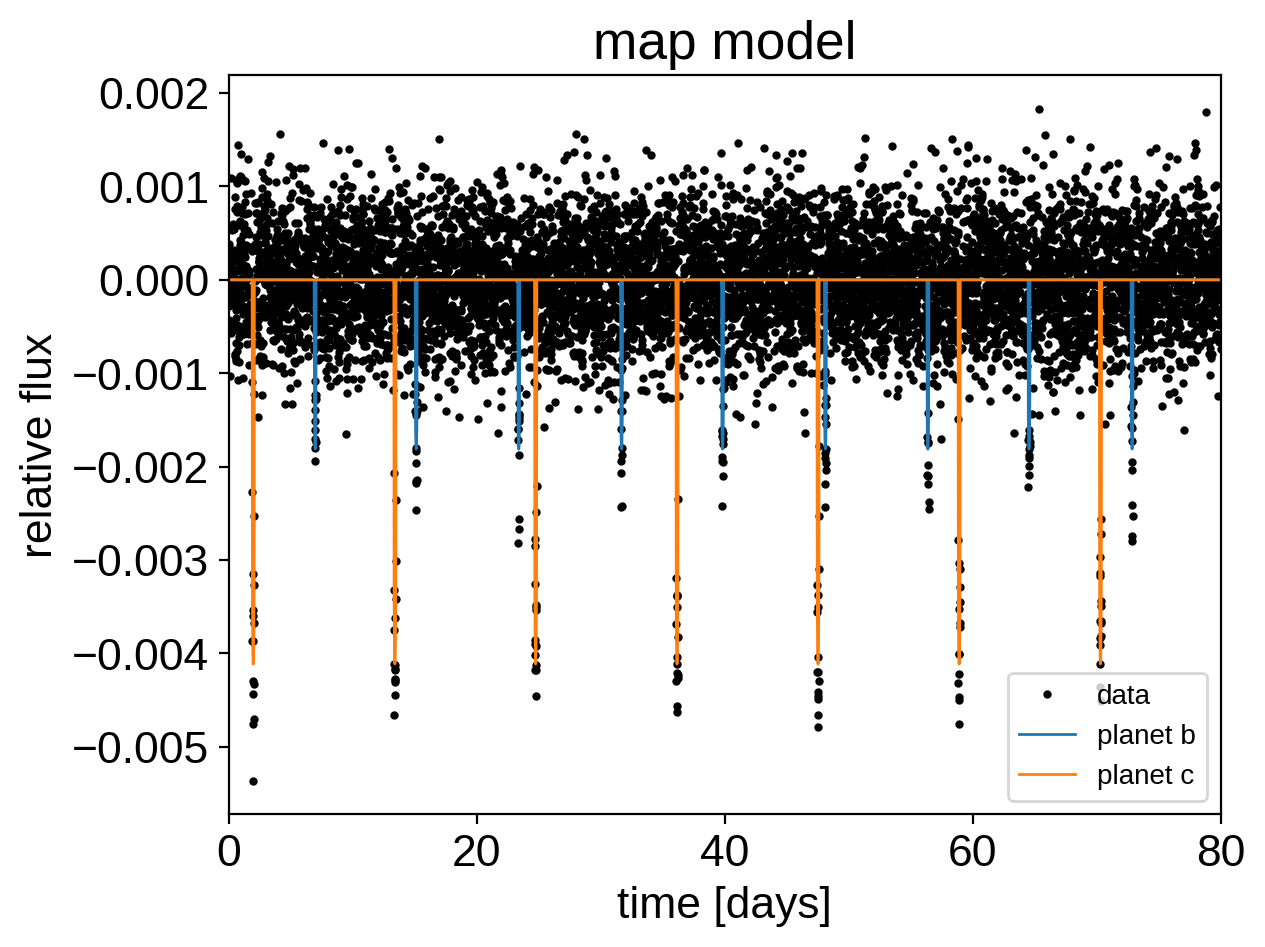

In [5]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

This looks similar to the light curve from the :ref:`transit` tutorial, but if we try plotting the folded transits, we can see that something isn't right: these transits look pretty smeared out!

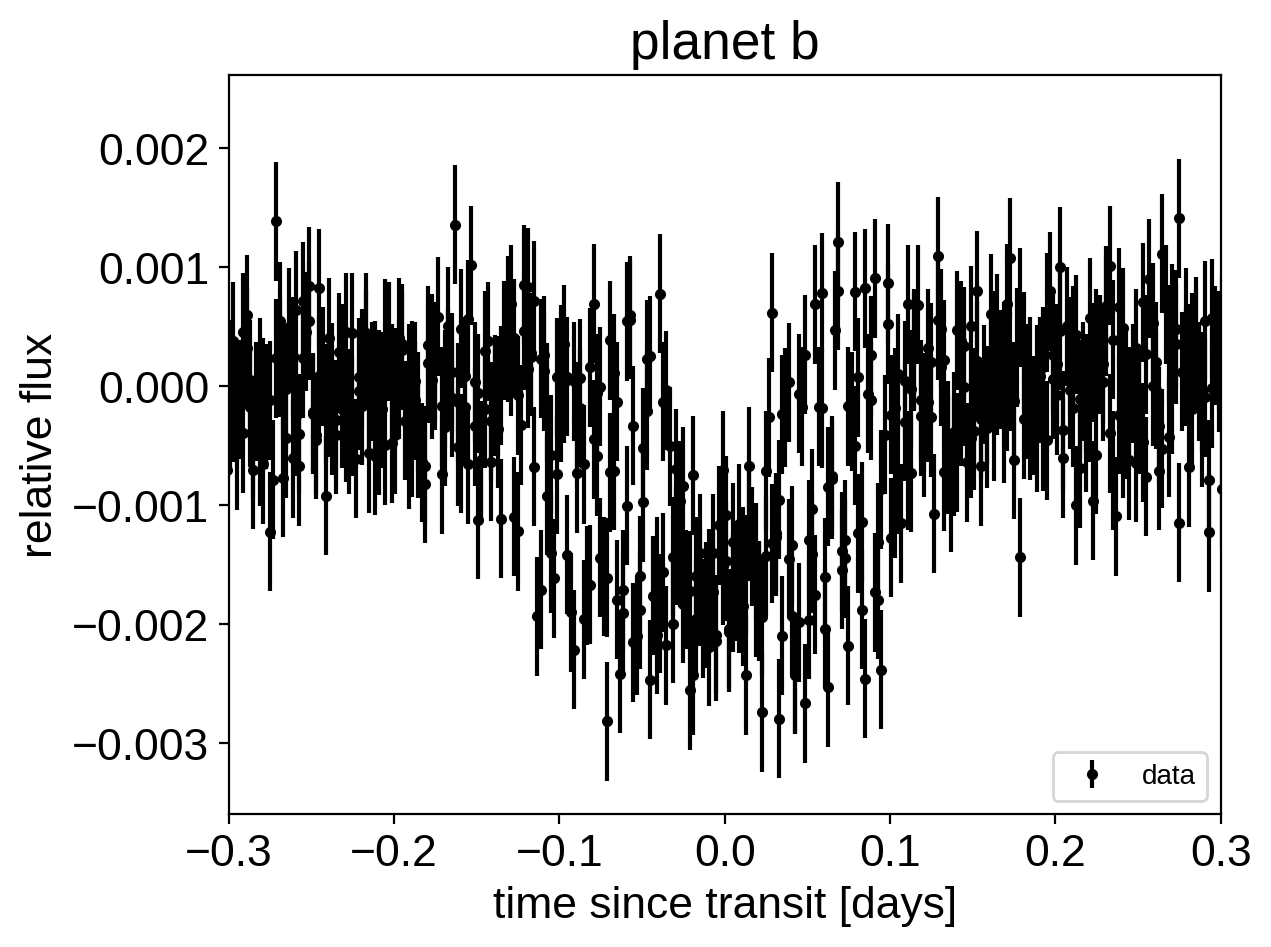

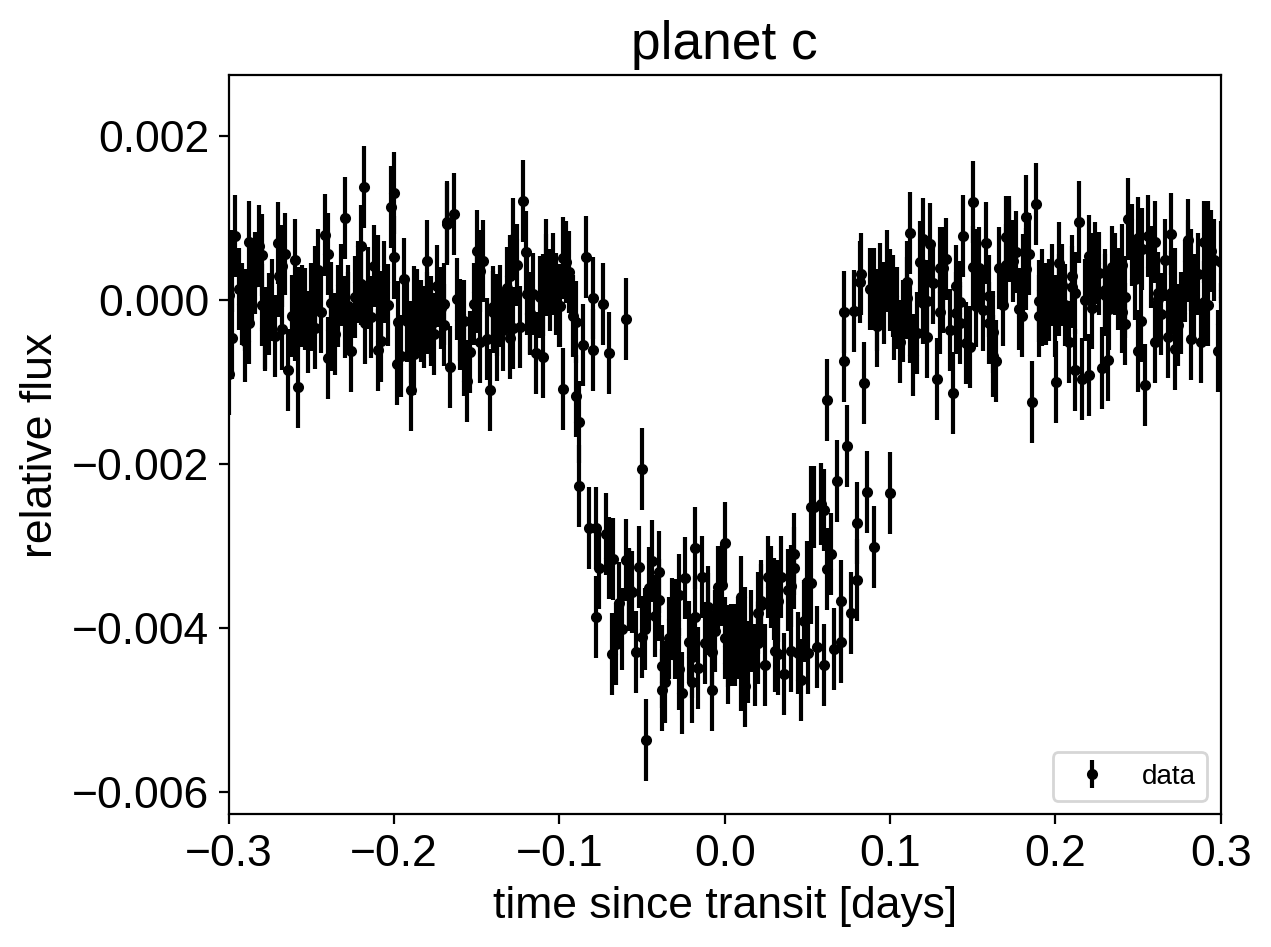

In [6]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = map_soln["period"][n]
    t0 = map_soln["t0"][n]

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

Instead, we can correct for the transit times by removing the best fit transit times and plot that instead:

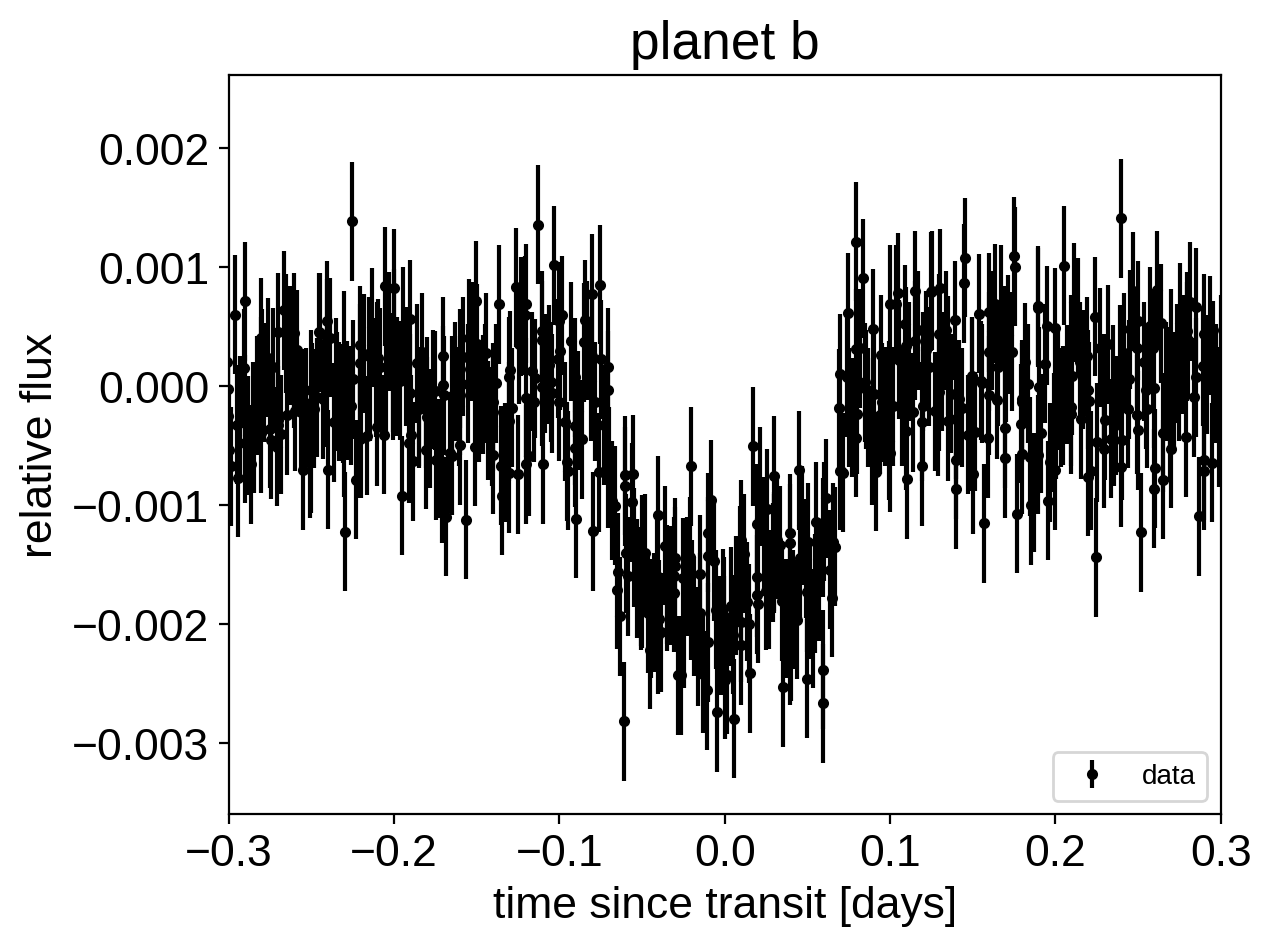

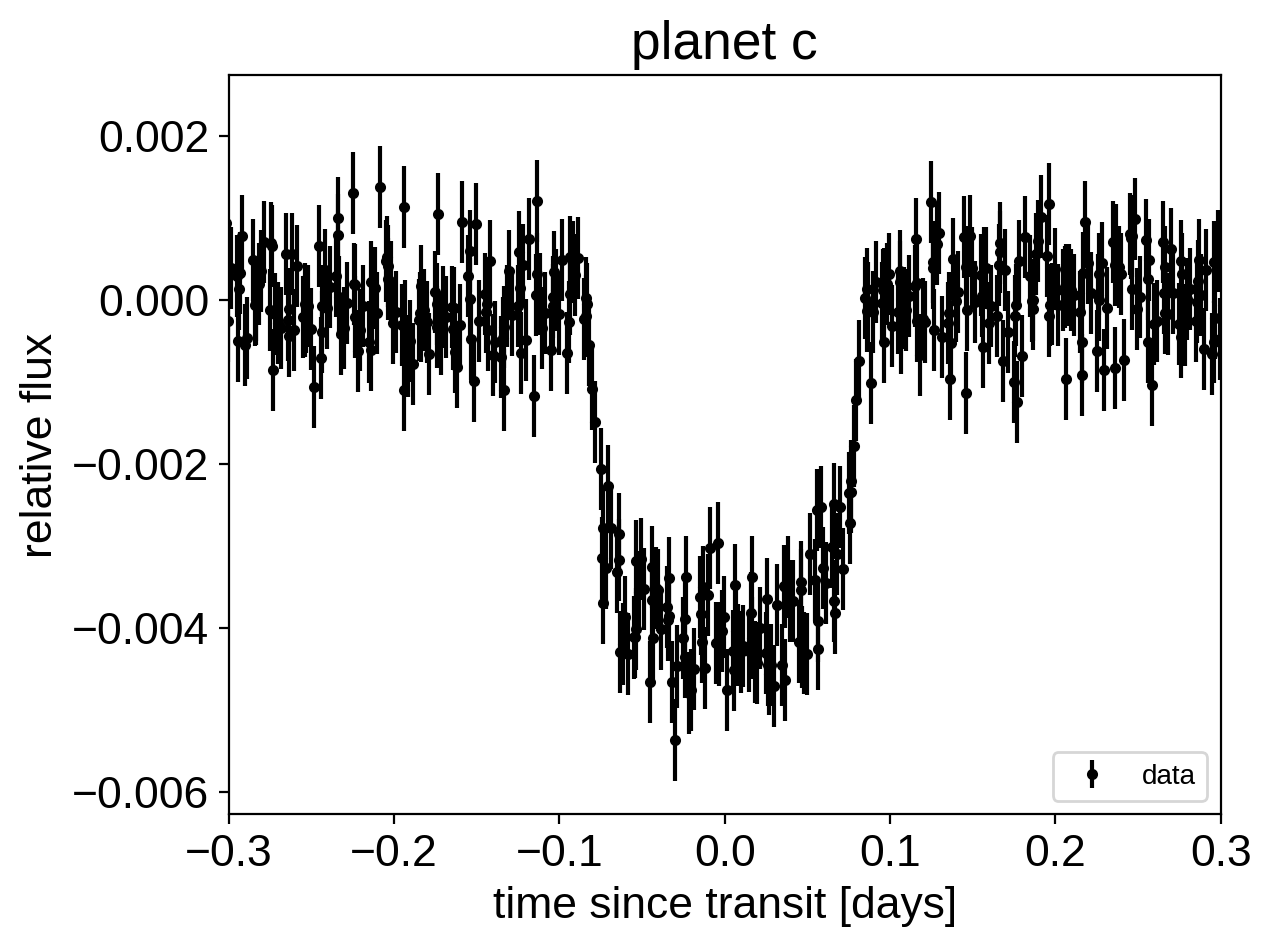

In [7]:
with model:
    t_warp = xo.eval_in_model(orbit._warp_times(t), map_soln)

for n, letter in enumerate("bc"):
    plt.figure()

    p = map_soln["period"][n]
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

That looks better!

## Sampling

Now let's run some MCMC as usual:

In [8]:
np.random.seed(230948)
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [tts_1, tts_0, b, logr, u, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/8000 [00:00<02:36, 51.04draws/s]

Sampling 4 chains:   0%|          | 25/8000 [00:00<06:04, 21.87draws/s]

Sampling 4 chains:   0%|          | 29/8000 [00:01<09:08, 14.54draws/s]

Sampling 4 chains:   0%|          | 31/8000 [00:01<09:20, 14.21draws/s]

Sampling 4 chains:   0%|          | 33/8000 [00:01<11:21, 11.68draws/s]

Sampling 4 chains:   0%|          | 35/8000 [00:01<10:37, 12.50draws/s]

Sampling 4 chains:   0%|          | 37/8000 [00:02<12:08, 10.93draws/s]

Sampling 4 chains:   0%|          | 39/8000 [00:02<11:16, 11.76draws/s]

Sampling 4 chains:   1%|          | 41/8000 [00:02<12:27, 10.65draws/s]

Sampling 4 chains:   1%|          | 43/8000 [00:02<11:54, 11.13draws/s]

Sampling 4 chains:   1%|          | 45/8000 [00:02<13:04, 10.14draws/s]

Sampling 4 chains:   1%|          | 47/8000 [00:03<12:39, 10.47draws/s]

Sampling 4 chains:   1%|          | 49/8000 [00:03<12:38, 10.48draws/s]

Sampling 4 chains:   1%|          | 51/8000 [00:03<12:27, 10.63draws/s]

Sampling 4 chains:   1%|          | 53/8000 [00:03<13:20,  9.93draws/s]

Sampling 4 chains:   1%|          | 55/8000 [00:03<14:56,  8.86draws/s]

Sampling 4 chains:   1%|          | 57/8000 [00:04<13:45,  9.62draws/s]

Sampling 4 chains:   1%|          | 59/8000 [00:04<14:21,  9.22draws/s]

Sampling 4 chains:   1%|          | 61/8000 [00:04<12:37, 10.48draws/s]

Sampling 4 chains:   1%|          | 63/8000 [00:04<11:06, 11.90draws/s]

Sampling 4 chains:   1%|          | 65/8000 [00:04<11:20, 11.67draws/s]

Sampling 4 chains:   1%|          | 67/8000 [00:04<11:47, 11.21draws/s]

Sampling 4 chains:   1%|          | 69/8000 [00:05<12:02, 10.98draws/s]

Sampling 4 chains:   1%|          | 72/8000 [00:05<10:47, 12.24draws/s]

Sampling 4 chains:   1%|          | 74/8000 [00:05<11:07, 11.88draws/s]

Sampling 4 chains:   1%|          | 77/8000 [00:05<10:19, 12.78draws/s]

Sampling 4 chains:   1%|          | 79/8000 [00:05<11:54, 11.09draws/s]

Sampling 4 chains:   1%|          | 81/8000 [00:06<11:30, 11.46draws/s]

Sampling 4 chains:   1%|          | 83/8000 [00:06<13:31,  9.75draws/s]

Sampling 4 chains:   1%|          | 85/8000 [00:06<11:31, 11.44draws/s]

Sampling 4 chains:   1%|          | 87/8000 [00:06<13:50,  9.53draws/s]

Sampling 4 chains:   1%|          | 91/8000 [00:07<12:56, 10.19draws/s]

Sampling 4 chains:   1%|          | 93/8000 [00:07<11:31, 11.43draws/s]

Sampling 4 chains:   1%|          | 95/8000 [00:07<13:45,  9.58draws/s]

Sampling 4 chains:   1%|          | 97/8000 [00:07<12:26, 10.58draws/s]

Sampling 4 chains:   1%|          | 99/8000 [00:07<14:03,  9.36draws/s]

Sampling 4 chains:   1%|▏         | 101/8000 [00:08<11:53, 11.07draws/s]

Sampling 4 chains:   1%|▏         | 103/8000 [00:08<13:50,  9.51draws/s]

Sampling 4 chains:   1%|▏         | 105/8000 [00:08<12:07, 10.85draws/s]

Sampling 4 chains:   1%|▏         | 108/8000 [00:08<14:05,  9.33draws/s]

Sampling 4 chains:   1%|▏         | 112/8000 [00:09<13:35,  9.67draws/s]

Sampling 4 chains:   1%|▏         | 116/8000 [00:09<13:11,  9.96draws/s]

Sampling 4 chains:   1%|▏         | 119/8000 [00:09<10:33, 12.45draws/s]

Sampling 4 chains:   2%|▏         | 121/8000 [00:10<14:44,  8.90draws/s]

Sampling 4 chains:   2%|▏         | 123/8000 [00:10<12:43, 10.32draws/s]

Sampling 4 chains:   2%|▏         | 125/8000 [00:10<13:52,  9.46draws/s]

Sampling 4 chains:   2%|▏         | 127/8000 [00:10<12:43, 10.31draws/s]

Sampling 4 chains:   2%|▏         | 129/8000 [00:10<13:09,  9.97draws/s]

Sampling 4 chains:   2%|▏         | 132/8000 [00:10<11:16, 11.62draws/s]

Sampling 4 chains:   2%|▏         | 134/8000 [00:11<12:34, 10.43draws/s]

Sampling 4 chains:   2%|▏         | 137/8000 [00:11<12:16, 10.67draws/s]

Sampling 4 chains:   2%|▏         | 139/8000 [00:11<11:25, 11.46draws/s]

Sampling 4 chains:   2%|▏         | 142/8000 [00:11<11:34, 11.31draws/s]

Sampling 4 chains:   2%|▏         | 144/8000 [00:12<10:38, 12.30draws/s]

Sampling 4 chains:   2%|▏         | 146/8000 [00:12<13:23,  9.77draws/s]

Sampling 4 chains:   2%|▏         | 149/8000 [00:12<11:14, 11.65draws/s]

Sampling 4 chains:   2%|▏         | 151/8000 [00:12<12:31, 10.45draws/s]

Sampling 4 chains:   2%|▏         | 154/8000 [00:12<10:42, 12.21draws/s]

Sampling 4 chains:   2%|▏         | 156/8000 [00:13<12:59, 10.06draws/s]

Sampling 4 chains:   2%|▏         | 159/8000 [00:13<13:31,  9.66draws/s]

Sampling 4 chains:   2%|▏         | 162/8000 [00:13<11:16, 11.59draws/s]

Sampling 4 chains:   2%|▏         | 164/8000 [00:13<13:18,  9.81draws/s]

Sampling 4 chains:   2%|▏         | 166/8000 [00:13<11:17, 11.57draws/s]

Sampling 4 chains:   2%|▏         | 168/8000 [00:14<13:13,  9.86draws/s]

Sampling 4 chains:   2%|▏         | 170/8000 [00:14<11:15, 11.60draws/s]

Sampling 4 chains:   2%|▏         | 172/8000 [00:14<13:36,  9.59draws/s]

Sampling 4 chains:   2%|▏         | 175/8000 [00:15<14:32,  8.97draws/s]

Sampling 4 chains:   2%|▏         | 178/8000 [00:15<12:03, 10.82draws/s]

Sampling 4 chains:   2%|▏         | 180/8000 [00:15<13:49,  9.43draws/s]

Sampling 4 chains:   2%|▏         | 182/8000 [00:15<12:22, 10.52draws/s]

Sampling 4 chains:   2%|▏         | 184/8000 [00:15<13:39,  9.53draws/s]

Sampling 4 chains:   2%|▏         | 186/8000 [00:16<13:42,  9.50draws/s]

Sampling 4 chains:   2%|▏         | 188/8000 [00:16<12:56, 10.06draws/s]

Sampling 4 chains:   2%|▏         | 190/8000 [00:16<13:17,  9.80draws/s]

Sampling 4 chains:   2%|▏         | 192/8000 [00:16<13:25,  9.69draws/s]

Sampling 4 chains:   2%|▏         | 194/8000 [00:16<13:16,  9.80draws/s]

Sampling 4 chains:   2%|▏         | 196/8000 [00:17<13:06,  9.93draws/s]

Sampling 4 chains:   2%|▏         | 198/8000 [00:17<12:49, 10.14draws/s]

Sampling 4 chains:   2%|▎         | 200/8000 [00:17<12:52, 10.10draws/s]

Sampling 4 chains:   3%|▎         | 202/8000 [00:17<12:24, 10.47draws/s]

Sampling 4 chains:   3%|▎         | 204/8000 [00:17<12:27, 10.42draws/s]

Sampling 4 chains:   3%|▎         | 206/8000 [00:18<12:15, 10.60draws/s]

Sampling 4 chains:   3%|▎         | 208/8000 [00:18<12:09, 10.68draws/s]

Sampling 4 chains:   3%|▎         | 210/8000 [00:18<12:11, 10.65draws/s]

Sampling 4 chains:   3%|▎         | 212/8000 [00:18<12:01, 10.79draws/s]

Sampling 4 chains:   3%|▎         | 214/8000 [00:18<12:51, 10.09draws/s]

Sampling 4 chains:   3%|▎         | 216/8000 [00:19<13:50,  9.38draws/s]

Sampling 4 chains:   3%|▎         | 218/8000 [00:19<13:34,  9.55draws/s]

Sampling 4 chains:   3%|▎         | 220/8000 [00:19<13:34,  9.55draws/s]

Sampling 4 chains:   3%|▎         | 222/8000 [00:19<12:48, 10.12draws/s]

Sampling 4 chains:   3%|▎         | 224/8000 [00:19<12:47, 10.13draws/s]

Sampling 4 chains:   3%|▎         | 226/8000 [00:19<12:22, 10.47draws/s]

Sampling 4 chains:   3%|▎         | 228/8000 [00:20<12:25, 10.43draws/s]

Sampling 4 chains:   3%|▎         | 230/8000 [00:20<12:07, 10.68draws/s]

Sampling 4 chains:   3%|▎         | 232/8000 [00:20<12:11, 10.61draws/s]

Sampling 4 chains:   3%|▎         | 234/8000 [00:20<12:02, 10.74draws/s]

Sampling 4 chains:   3%|▎         | 236/8000 [00:20<12:06, 10.69draws/s]

Sampling 4 chains:   3%|▎         | 238/8000 [00:21<12:02, 10.74draws/s]

Sampling 4 chains:   3%|▎         | 240/8000 [00:21<11:59, 10.78draws/s]

Sampling 4 chains:   3%|▎         | 242/8000 [00:21<12:01, 10.75draws/s]

Sampling 4 chains:   3%|▎         | 244/8000 [00:21<11:54, 10.86draws/s]

Sampling 4 chains:   3%|▎         | 246/8000 [00:21<12:02, 10.74draws/s]

Sampling 4 chains:   3%|▎         | 248/8000 [00:22<11:55, 10.83draws/s]

Sampling 4 chains:   3%|▎         | 250/8000 [00:22<12:44, 10.14draws/s]

Sampling 4 chains:   3%|▎         | 252/8000 [00:22<12:14, 10.54draws/s]

Sampling 4 chains:   3%|▎         | 254/8000 [00:22<13:03,  9.88draws/s]

Sampling 4 chains:   3%|▎         | 256/8000 [00:22<11:53, 10.85draws/s]

Sampling 4 chains:   3%|▎         | 258/8000 [00:23<14:03,  9.18draws/s]

Sampling 4 chains:   3%|▎         | 259/8000 [00:23<16:45,  7.70draws/s]

Sampling 4 chains:   3%|▎         | 261/8000 [00:23<14:08,  9.12draws/s]

Sampling 4 chains:   3%|▎         | 263/8000 [00:23<15:30,  8.32draws/s]

Sampling 4 chains:   3%|▎         | 266/8000 [00:23<13:49,  9.32draws/s]

Sampling 4 chains:   3%|▎         | 268/8000 [00:24<12:30, 10.31draws/s]

Sampling 4 chains:   3%|▎         | 271/8000 [00:24<12:39, 10.17draws/s]

Sampling 4 chains:   3%|▎         | 273/8000 [00:24<13:44,  9.37draws/s]

Sampling 4 chains:   3%|▎         | 275/8000 [00:24<12:48, 10.05draws/s]

Sampling 4 chains:   3%|▎         | 277/8000 [00:25<13:50,  9.30draws/s]

Sampling 4 chains:   3%|▎         | 279/8000 [00:25<11:57, 10.77draws/s]

Sampling 4 chains:   4%|▎         | 281/8000 [00:25<13:37,  9.45draws/s]

Sampling 4 chains:   4%|▎         | 283/8000 [00:25<11:53, 10.81draws/s]

Sampling 4 chains:   4%|▎         | 285/8000 [00:25<13:57,  9.21draws/s]

Sampling 4 chains:   4%|▎         | 287/8000 [00:25<11:42, 10.98draws/s]

Sampling 4 chains:   4%|▎         | 289/8000 [00:26<13:29,  9.52draws/s]

Sampling 4 chains:   4%|▎         | 291/8000 [00:26<11:39, 11.02draws/s]

Sampling 4 chains:   4%|▎         | 293/8000 [00:26<13:13,  9.72draws/s]

Sampling 4 chains:   4%|▎         | 295/8000 [00:26<11:28, 11.20draws/s]

Sampling 4 chains:   4%|▎         | 297/8000 [00:26<12:19, 10.42draws/s]

Sampling 4 chains:   4%|▍         | 300/8000 [00:27<11:44, 10.93draws/s]

Sampling 4 chains:   4%|▍         | 302/8000 [00:27<12:26, 10.31draws/s]

Sampling 4 chains:   4%|▍         | 304/8000 [00:27<11:54, 10.78draws/s]

Sampling 4 chains:   4%|▍         | 306/8000 [00:27<12:14, 10.47draws/s]

Sampling 4 chains:   4%|▍         | 308/8000 [00:27<11:58, 10.71draws/s]

Sampling 4 chains:   4%|▍         | 310/8000 [00:28<12:06, 10.58draws/s]

Sampling 4 chains:   4%|▍         | 312/8000 [00:28<12:45, 10.04draws/s]

Sampling 4 chains:   4%|▍         | 314/8000 [00:28<12:13, 10.48draws/s]

Sampling 4 chains:   4%|▍         | 316/8000 [00:28<12:22, 10.34draws/s]

Sampling 4 chains:   4%|▍         | 318/8000 [00:28<12:05, 10.59draws/s]

Sampling 4 chains:   4%|▍         | 320/8000 [00:29<12:39, 10.12draws/s]

Sampling 4 chains:   4%|▍         | 322/8000 [00:29<13:19,  9.61draws/s]

Sampling 4 chains:   4%|▍         | 323/8000 [00:29<17:22,  7.37draws/s]

Sampling 4 chains:   4%|▍         | 325/8000 [00:29<14:38,  8.74draws/s]

Sampling 4 chains:   4%|▍         | 327/8000 [00:29<14:51,  8.61draws/s]

Sampling 4 chains:   4%|▍         | 329/8000 [00:30<12:51,  9.94draws/s]

Sampling 4 chains:   4%|▍         | 331/8000 [00:30<14:10,  9.01draws/s]

Sampling 4 chains:   4%|▍         | 333/8000 [00:30<12:32, 10.19draws/s]

Sampling 4 chains:   4%|▍         | 335/8000 [00:30<13:21,  9.56draws/s]

Sampling 4 chains:   4%|▍         | 337/8000 [00:30<12:03, 10.59draws/s]

Sampling 4 chains:   4%|▍         | 339/8000 [00:31<12:54,  9.89draws/s]

Sampling 4 chains:   4%|▍         | 341/8000 [00:31<12:38, 10.10draws/s]

Sampling 4 chains:   4%|▍         | 343/8000 [00:31<14:28,  8.82draws/s]

Sampling 4 chains:   4%|▍         | 345/8000 [00:31<14:04,  9.06draws/s]

Sampling 4 chains:   4%|▍         | 346/8000 [00:31<14:50,  8.59draws/s]

Sampling 4 chains:   4%|▍         | 348/8000 [00:32<13:22,  9.53draws/s]

Sampling 4 chains:   4%|▍         | 350/8000 [00:32<13:47,  9.25draws/s]

Sampling 4 chains:   4%|▍         | 352/8000 [00:32<12:33, 10.15draws/s]

Sampling 4 chains:   4%|▍         | 354/8000 [00:32<13:18,  9.57draws/s]

Sampling 4 chains:   4%|▍         | 356/8000 [00:32<12:01, 10.59draws/s]

Sampling 4 chains:   4%|▍         | 358/8000 [00:33<12:58,  9.82draws/s]

Sampling 4 chains:   4%|▍         | 360/8000 [00:33<11:44, 10.85draws/s]

Sampling 4 chains:   5%|▍         | 362/8000 [00:33<12:47,  9.96draws/s]

Sampling 4 chains:   5%|▍         | 364/8000 [00:33<11:41, 10.89draws/s]

Sampling 4 chains:   5%|▍         | 366/8000 [00:33<12:47,  9.95draws/s]

Sampling 4 chains:   5%|▍         | 368/8000 [00:33<11:43, 10.84draws/s]

Sampling 4 chains:   5%|▍         | 370/8000 [00:34<13:40,  9.30draws/s]

Sampling 4 chains:   5%|▍         | 372/8000 [00:34<12:58,  9.80draws/s]

Sampling 4 chains:   5%|▍         | 374/8000 [00:34<13:17,  9.57draws/s]

Sampling 4 chains:   5%|▍         | 376/8000 [00:34<12:17, 10.34draws/s]

Sampling 4 chains:   5%|▍         | 378/8000 [00:35<12:39, 10.03draws/s]

Sampling 4 chains:   5%|▍         | 380/8000 [00:35<13:46,  9.22draws/s]

Sampling 4 chains:   5%|▍         | 382/8000 [00:35<13:00,  9.77draws/s]

Sampling 4 chains:   5%|▍         | 384/8000 [00:35<14:41,  8.64draws/s]

Sampling 4 chains:   5%|▍         | 386/8000 [00:35<12:11, 10.41draws/s]

Sampling 4 chains:   5%|▍         | 388/8000 [00:36<13:56,  9.10draws/s]

Sampling 4 chains:   5%|▍         | 390/8000 [00:36<11:42, 10.83draws/s]

Sampling 4 chains:   5%|▍         | 392/8000 [00:36<14:01,  9.04draws/s]

Sampling 4 chains:   5%|▍         | 395/8000 [00:36<11:29, 11.03draws/s]

Sampling 4 chains:   5%|▍         | 397/8000 [00:37<14:11,  8.93draws/s]

Sampling 4 chains:   5%|▌         | 400/8000 [00:37<13:49,  9.16draws/s]

Sampling 4 chains:   5%|▌         | 402/8000 [00:37<12:58,  9.75draws/s]

Sampling 4 chains:   5%|▌         | 404/8000 [00:37<14:03,  9.01draws/s]

Sampling 4 chains:   5%|▌         | 406/8000 [00:37<12:20, 10.25draws/s]

Sampling 4 chains:   5%|▌         | 408/8000 [00:38<13:28,  9.39draws/s]

Sampling 4 chains:   5%|▌         | 410/8000 [00:38<11:49, 10.70draws/s]

Sampling 4 chains:   5%|▌         | 412/8000 [00:38<13:27,  9.39draws/s]

Sampling 4 chains:   5%|▌         | 414/8000 [00:38<13:16,  9.52draws/s]

Sampling 4 chains:   5%|▌         | 416/8000 [00:39<14:28,  8.73draws/s]

Sampling 4 chains:   5%|▌         | 418/8000 [00:39<12:54,  9.79draws/s]

Sampling 4 chains:   5%|▌         | 420/8000 [00:39<13:36,  9.29draws/s]

Sampling 4 chains:   5%|▌         | 422/8000 [00:39<12:03, 10.48draws/s]

Sampling 4 chains:   5%|▌         | 424/8000 [00:39<13:24,  9.42draws/s]

Sampling 4 chains:   5%|▌         | 426/8000 [00:39<11:28, 11.00draws/s]

Sampling 4 chains:   5%|▌         | 428/8000 [00:40<13:13,  9.54draws/s]

Sampling 4 chains:   5%|▌         | 430/8000 [00:40<11:22, 11.09draws/s]

Sampling 4 chains:   5%|▌         | 432/8000 [00:40<13:33,  9.30draws/s]

Sampling 4 chains:   5%|▌         | 434/8000 [00:40<11:40, 10.80draws/s]

Sampling 4 chains:   5%|▌         | 436/8000 [00:40<13:09,  9.58draws/s]

Sampling 4 chains:   5%|▌         | 438/8000 [00:41<11:51, 10.63draws/s]

Sampling 4 chains:   6%|▌         | 440/8000 [00:41<14:58,  8.42draws/s]

Sampling 4 chains:   6%|▌         | 442/8000 [00:41<13:38,  9.24draws/s]

Sampling 4 chains:   6%|▌         | 444/8000 [00:41<14:18,  8.80draws/s]

Sampling 4 chains:   6%|▌         | 446/8000 [00:42<12:58,  9.70draws/s]

Sampling 4 chains:   6%|▌         | 448/8000 [00:42<13:23,  9.40draws/s]

Sampling 4 chains:   6%|▌         | 450/8000 [00:42<12:40,  9.92draws/s]

Sampling 4 chains:   6%|▌         | 452/8000 [00:42<13:07,  9.59draws/s]

Sampling 4 chains:   6%|▌         | 454/8000 [00:42<12:06, 10.39draws/s]

Sampling 4 chains:   6%|▌         | 456/8000 [00:43<12:47,  9.83draws/s]

Sampling 4 chains:   6%|▌         | 458/8000 [00:43<11:45, 10.69draws/s]

Sampling 4 chains:   6%|▌         | 460/8000 [00:43<12:32, 10.02draws/s]

Sampling 4 chains:   6%|▌         | 462/8000 [00:43<11:57, 10.51draws/s]

Sampling 4 chains:   6%|▌         | 464/8000 [00:43<13:10,  9.53draws/s]

Sampling 4 chains:   6%|▌         | 466/8000 [00:43<11:38, 10.79draws/s]

Sampling 4 chains:   6%|▌         | 468/8000 [00:44<12:59,  9.67draws/s]

Sampling 4 chains:   6%|▌         | 470/8000 [00:44<11:17, 11.11draws/s]

Sampling 4 chains:   6%|▌         | 472/8000 [00:44<12:55,  9.71draws/s]

Sampling 4 chains:   6%|▌         | 474/8000 [00:44<11:11, 11.20draws/s]

Sampling 4 chains:   6%|▌         | 476/8000 [00:45<13:44,  9.12draws/s]

Sampling 4 chains:   6%|▌         | 478/8000 [00:45<11:38, 10.76draws/s]

Sampling 4 chains:   6%|▌         | 480/8000 [00:45<13:18,  9.41draws/s]

Sampling 4 chains:   6%|▌         | 482/8000 [00:45<11:14, 11.14draws/s]

Sampling 4 chains:   6%|▌         | 484/8000 [00:45<13:46,  9.09draws/s]

Sampling 4 chains:   6%|▌         | 486/8000 [00:46<13:16,  9.43draws/s]

Sampling 4 chains:   6%|▌         | 488/8000 [00:46<14:34,  8.59draws/s]

Sampling 4 chains:   6%|▌         | 489/8000 [00:46<14:00,  8.93draws/s]

Sampling 4 chains:   6%|▌         | 491/8000 [00:46<14:18,  8.74draws/s]

Sampling 4 chains:   6%|▌         | 493/8000 [00:46<13:12,  9.47draws/s]

Sampling 4 chains:   6%|▌         | 495/8000 [00:47<13:03,  9.58draws/s]

Sampling 4 chains:   6%|▌         | 497/8000 [00:47<12:24, 10.07draws/s]

Sampling 4 chains:   6%|▌         | 499/8000 [00:47<13:30,  9.25draws/s]

Sampling 4 chains:   6%|▋         | 501/8000 [00:47<12:40,  9.86draws/s]

Sampling 4 chains:   6%|▋         | 503/8000 [00:47<13:59,  8.93draws/s]

Sampling 4 chains:   6%|▋         | 505/8000 [00:48<12:06, 10.32draws/s]

Sampling 4 chains:   6%|▋         | 507/8000 [00:48<13:07,  9.51draws/s]

Sampling 4 chains:   6%|▋         | 509/8000 [00:48<11:39, 10.71draws/s]

Sampling 4 chains:   6%|▋         | 511/8000 [00:48<13:13,  9.44draws/s]

Sampling 4 chains:   6%|▋         | 513/8000 [00:48<12:45,  9.78draws/s]

Sampling 4 chains:   6%|▋         | 515/8000 [00:49<12:45,  9.77draws/s]

Sampling 4 chains:   6%|▋         | 517/8000 [00:49<12:28, 10.00draws/s]

Sampling 4 chains:   6%|▋         | 519/8000 [00:49<12:19, 10.12draws/s]

Sampling 4 chains:   7%|▋         | 521/8000 [00:49<12:16, 10.15draws/s]

Sampling 4 chains:   7%|▋         | 523/8000 [00:49<12:48,  9.73draws/s]

Sampling 4 chains:   7%|▋         | 524/8000 [00:50<14:51,  8.39draws/s]

Sampling 4 chains:   7%|▋         | 527/8000 [00:50<13:07,  9.49draws/s]

Sampling 4 chains:   7%|▋         | 529/8000 [00:50<12:43,  9.79draws/s]

Sampling 4 chains:   7%|▋         | 531/8000 [00:50<12:41,  9.81draws/s]

Sampling 4 chains:   7%|▋         | 533/8000 [00:50<12:15, 10.15draws/s]

Sampling 4 chains:   7%|▋         | 535/8000 [00:51<12:29,  9.96draws/s]

Sampling 4 chains:   7%|▋         | 537/8000 [00:51<11:58, 10.39draws/s]

Sampling 4 chains:   7%|▋         | 539/8000 [00:51<12:40,  9.81draws/s]

Sampling 4 chains:   7%|▋         | 541/8000 [00:51<11:46, 10.56draws/s]

Sampling 4 chains:   7%|▋         | 543/8000 [00:51<12:27,  9.98draws/s]

Sampling 4 chains:   7%|▋         | 545/8000 [00:51<11:39, 10.66draws/s]

Sampling 4 chains:   7%|▋         | 547/8000 [00:52<13:26,  9.24draws/s]

Sampling 4 chains:   7%|▋         | 549/8000 [00:52<11:46, 10.55draws/s]

Sampling 4 chains:   7%|▋         | 551/8000 [00:52<13:31,  9.18draws/s]

Sampling 4 chains:   7%|▋         | 554/8000 [00:52<11:14, 11.04draws/s]

Sampling 4 chains:   7%|▋         | 556/8000 [00:53<12:27,  9.96draws/s]

Sampling 4 chains:   7%|▋         | 558/8000 [00:53<12:16, 10.11draws/s]

Sampling 4 chains:   7%|▋         | 560/8000 [00:53<13:44,  9.03draws/s]

Sampling 4 chains:   7%|▋         | 562/8000 [00:53<15:25,  8.04draws/s]

Sampling 4 chains:   7%|▋         | 563/8000 [00:53<14:39,  8.45draws/s]

Sampling 4 chains:   7%|▋         | 566/8000 [00:54<13:32,  9.15draws/s]

Sampling 4 chains:   7%|▋         | 567/8000 [00:54<13:22,  9.26draws/s]

Sampling 4 chains:   7%|▋         | 570/8000 [00:54<13:29,  9.17draws/s]

Sampling 4 chains:   7%|▋         | 572/8000 [00:54<12:37,  9.80draws/s]

Sampling 4 chains:   7%|▋         | 574/8000 [00:55<13:45,  9.00draws/s]

Sampling 4 chains:   7%|▋         | 576/8000 [00:55<11:42, 10.57draws/s]

Sampling 4 chains:   7%|▋         | 578/8000 [00:55<12:59,  9.53draws/s]

Sampling 4 chains:   7%|▋         | 580/8000 [00:55<11:08, 11.10draws/s]

Sampling 4 chains:   7%|▋         | 582/8000 [00:55<10:53, 11.35draws/s]

Sampling 4 chains:   7%|▋         | 584/8000 [00:55<11:36, 10.65draws/s]

Sampling 4 chains:   7%|▋         | 586/8000 [00:56<11:43, 10.54draws/s]

Sampling 4 chains:   7%|▋         | 588/8000 [00:56<10:39, 11.59draws/s]

Sampling 4 chains:   7%|▋         | 590/8000 [00:56<12:48,  9.65draws/s]

Sampling 4 chains:   7%|▋         | 592/8000 [00:56<10:58, 11.25draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [00:57<13:30,  9.13draws/s]

Sampling 4 chains:   7%|▋         | 597/8000 [00:57<11:45, 10.49draws/s]

Sampling 4 chains:   7%|▋         | 599/8000 [00:57<12:48,  9.63draws/s]

Sampling 4 chains:   8%|▊         | 601/8000 [00:57<11:26, 10.78draws/s]

Sampling 4 chains:   8%|▊         | 605/8000 [00:57<11:29, 10.73draws/s]

Sampling 4 chains:   8%|▊         | 611/8000 [00:58<09:13, 13.35draws/s]

Sampling 4 chains:   8%|▊         | 614/8000 [00:58<08:44, 14.09draws/s]

Sampling 4 chains:   8%|▊         | 617/8000 [00:58<07:34, 16.23draws/s]

Sampling 4 chains:   8%|▊         | 619/8000 [00:58<07:20, 16.77draws/s]

Sampling 4 chains:   8%|▊         | 621/8000 [00:58<10:04, 12.20draws/s]

Sampling 4 chains:   8%|▊         | 623/8000 [00:58<09:10, 13.40draws/s]

Sampling 4 chains:   8%|▊         | 625/8000 [00:59<11:17, 10.89draws/s]

Sampling 4 chains:   8%|▊         | 627/8000 [00:59<10:04, 12.19draws/s]

Sampling 4 chains:   8%|▊         | 629/8000 [00:59<10:27, 11.74draws/s]

Sampling 4 chains:   8%|▊         | 633/8000 [00:59<08:51, 13.85draws/s]

Sampling 4 chains:   8%|▊         | 637/8000 [00:59<07:30, 16.34draws/s]

Sampling 4 chains:   8%|▊         | 642/8000 [00:59<06:18, 19.44draws/s]

Sampling 4 chains:   8%|▊         | 646/8000 [01:00<05:40, 21.63draws/s]

Sampling 4 chains:   8%|▊         | 650/8000 [01:00<05:22, 22.79draws/s]

Sampling 4 chains:   8%|▊         | 654/8000 [01:00<05:26, 22.50draws/s]

Sampling 4 chains:   8%|▊         | 657/8000 [01:00<05:31, 22.17draws/s]

Sampling 4 chains:   8%|▊         | 660/8000 [01:00<05:56, 20.61draws/s]

Sampling 4 chains:   8%|▊         | 666/8000 [01:00<04:49, 25.32draws/s]

Sampling 4 chains:   8%|▊         | 670/8000 [01:01<05:49, 20.98draws/s]

Sampling 4 chains:   8%|▊         | 673/8000 [01:01<05:28, 22.29draws/s]

Sampling 4 chains:   8%|▊         | 678/8000 [01:01<04:33, 26.72draws/s]

Sampling 4 chains:   9%|▊         | 682/8000 [01:01<04:23, 27.80draws/s]

Sampling 4 chains:   9%|▊         | 688/8000 [01:01<03:47, 32.11draws/s]

Sampling 4 chains:   9%|▊         | 695/8000 [01:01<03:11, 38.19draws/s]

Sampling 4 chains:   9%|▉         | 700/8000 [01:01<02:58, 41.00draws/s]

Sampling 4 chains:   9%|▉         | 705/8000 [01:01<03:24, 35.71draws/s]

Sampling 4 chains:   9%|▉         | 715/8000 [01:02<02:46, 43.84draws/s]

Sampling 4 chains:   9%|▉         | 721/8000 [01:02<02:37, 46.32draws/s]

Sampling 4 chains:   9%|▉         | 728/8000 [01:02<02:22, 51.20draws/s]

Sampling 4 chains:   9%|▉         | 736/8000 [01:02<02:08, 56.67draws/s]

Sampling 4 chains:   9%|▉         | 745/8000 [01:02<01:54, 63.37draws/s]

Sampling 4 chains:   9%|▉         | 753/8000 [01:02<01:49, 66.27draws/s]

Sampling 4 chains:  10%|▉         | 761/8000 [01:02<01:52, 64.62draws/s]

Sampling 4 chains:  10%|▉         | 770/8000 [01:02<01:46, 67.95draws/s]

Sampling 4 chains:  10%|▉         | 783/8000 [01:02<01:33, 76.93draws/s]

Sampling 4 chains:  10%|▉         | 797/8000 [01:03<01:27, 82.73draws/s]

Sampling 4 chains:  10%|█         | 806/8000 [01:03<01:28, 81.04draws/s]

Sampling 4 chains:  10%|█         | 816/8000 [01:03<01:23, 85.85draws/s]

Sampling 4 chains:  10%|█         | 827/8000 [01:03<01:19, 89.92draws/s]

Sampling 4 chains:  10%|█         | 840/8000 [01:03<01:14, 96.03draws/s]

Sampling 4 chains:  11%|█         | 850/8000 [01:03<01:21, 88.09draws/s]

Sampling 4 chains:  11%|█         | 862/8000 [01:03<01:15, 95.15draws/s]

Sampling 4 chains:  11%|█         | 872/8000 [01:03<01:15, 94.99draws/s]

Sampling 4 chains:  11%|█         | 882/8000 [01:04<01:18, 90.68draws/s]

Sampling 4 chains:  11%|█         | 892/8000 [01:04<01:16, 92.71draws/s]

Sampling 4 chains:  11%|█▏        | 905/8000 [01:04<01:12, 98.52draws/s]

Sampling 4 chains:  11%|█▏        | 918/8000 [01:04<01:07, 105.66draws/s]

Sampling 4 chains:  12%|█▏        | 929/8000 [01:04<01:09, 102.28draws/s]

Sampling 4 chains:  12%|█▏        | 943/8000 [01:04<01:04, 109.23draws/s]

Sampling 4 chains:  12%|█▏        | 958/8000 [01:04<00:59, 117.37draws/s]

Sampling 4 chains:  12%|█▏        | 976/8000 [01:04<00:54, 127.73draws/s]

Sampling 4 chains:  12%|█▏        | 990/8000 [01:04<00:55, 126.02draws/s]

Sampling 4 chains:  13%|█▎        | 1005/8000 [01:04<00:54, 129.52draws/s]

Sampling 4 chains:  13%|█▎        | 1020/8000 [01:05<00:52, 133.84draws/s]

Sampling 4 chains:  13%|█▎        | 1037/8000 [01:05<00:49, 140.24draws/s]

Sampling 4 chains:  13%|█▎        | 1052/8000 [01:05<00:52, 131.34draws/s]

Sampling 4 chains:  13%|█▎        | 1068/8000 [01:05<00:50, 138.61draws/s]

Sampling 4 chains:  14%|█▎        | 1083/8000 [01:05<00:50, 135.98draws/s]

Sampling 4 chains:  14%|█▎        | 1097/8000 [01:05<00:51, 133.46draws/s]

Sampling 4 chains:  14%|█▍        | 1111/8000 [01:05<00:51, 134.98draws/s]

Sampling 4 chains:  14%|█▍        | 1130/8000 [01:05<00:47, 146.13draws/s]

Sampling 4 chains:  14%|█▍        | 1148/8000 [01:05<00:44, 154.42draws/s]

Sampling 4 chains:  15%|█▍        | 1167/8000 [01:06<00:42, 161.72draws/s]

Sampling 4 chains:  15%|█▍        | 1190/8000 [01:06<00:38, 175.12draws/s]

Sampling 4 chains:  15%|█▌        | 1209/8000 [01:06<00:38, 176.42draws/s]

Sampling 4 chains:  15%|█▌        | 1228/8000 [01:06<00:40, 168.24draws/s]

Sampling 4 chains:  16%|█▌        | 1246/8000 [01:06<00:42, 157.64draws/s]

Sampling 4 chains:  16%|█▌        | 1263/8000 [01:06<00:44, 152.49draws/s]

Sampling 4 chains:  16%|█▌        | 1283/8000 [01:06<00:40, 164.02draws/s]

Sampling 4 chains:  16%|█▋        | 1301/8000 [01:06<00:41, 162.64draws/s]

Sampling 4 chains:  16%|█▋        | 1319/8000 [01:06<00:39, 167.30draws/s]

Sampling 4 chains:  17%|█▋        | 1339/8000 [01:07<00:37, 175.82draws/s]

Sampling 4 chains:  17%|█▋        | 1357/8000 [01:07<00:39, 170.08draws/s]

Sampling 4 chains:  17%|█▋        | 1375/8000 [01:07<00:39, 169.39draws/s]

Sampling 4 chains:  17%|█▋        | 1394/8000 [01:07<00:37, 174.22draws/s]

Sampling 4 chains:  18%|█▊        | 1412/8000 [01:07<00:41, 160.00draws/s]

Sampling 4 chains:  18%|█▊        | 1431/8000 [01:07<00:39, 167.07draws/s]

Sampling 4 chains:  18%|█▊        | 1451/8000 [01:07<00:37, 174.95draws/s]

Sampling 4 chains:  18%|█▊        | 1469/8000 [01:07<00:37, 172.61draws/s]

Sampling 4 chains:  19%|█▊        | 1487/8000 [01:07<00:37, 174.66draws/s]

Sampling 4 chains:  19%|█▉        | 1505/8000 [01:08<00:37, 171.21draws/s]

Sampling 4 chains:  19%|█▉        | 1523/8000 [01:08<00:40, 159.17draws/s]

Sampling 4 chains:  19%|█▉        | 1540/8000 [01:08<00:42, 153.69draws/s]

Sampling 4 chains:  19%|█▉        | 1556/8000 [01:08<00:44, 144.27draws/s]

Sampling 4 chains:  20%|█▉        | 1572/8000 [01:08<00:44, 143.41draws/s]

Sampling 4 chains:  20%|█▉        | 1587/8000 [01:08<00:45, 140.02draws/s]

Sampling 4 chains:  20%|██        | 1606/8000 [01:08<00:42, 151.37draws/s]

Sampling 4 chains:  20%|██        | 1623/8000 [01:08<00:42, 151.46draws/s]

Sampling 4 chains:  20%|██        | 1639/8000 [01:08<00:42, 149.14draws/s]

Sampling 4 chains:  21%|██        | 1655/8000 [01:09<00:47, 133.29draws/s]

Sampling 4 chains:  21%|██        | 1669/8000 [01:09<00:47, 132.08draws/s]

Sampling 4 chains:  21%|██        | 1683/8000 [01:09<00:50, 124.36draws/s]

Sampling 4 chains:  21%|██        | 1699/8000 [01:09<00:48, 130.03draws/s]

Sampling 4 chains:  21%|██▏       | 1718/8000 [01:09<00:44, 142.75draws/s]

Sampling 4 chains:  22%|██▏       | 1739/8000 [01:09<00:39, 157.40draws/s]

Sampling 4 chains:  22%|██▏       | 1756/8000 [01:09<00:39, 156.78draws/s]

Sampling 4 chains:  22%|██▏       | 1774/8000 [01:09<00:38, 162.99draws/s]

Sampling 4 chains:  22%|██▏       | 1791/8000 [01:10<00:38, 162.49draws/s]

Sampling 4 chains:  23%|██▎       | 1810/8000 [01:10<00:36, 169.75draws/s]

Sampling 4 chains:  23%|██▎       | 1828/8000 [01:10<00:36, 169.34draws/s]

Sampling 4 chains:  23%|██▎       | 1846/8000 [01:10<00:35, 171.71draws/s]

Sampling 4 chains:  23%|██▎       | 1865/8000 [01:10<00:34, 175.54draws/s]

Sampling 4 chains:  24%|██▎       | 1883/8000 [01:10<00:36, 168.80draws/s]

Sampling 4 chains:  24%|██▍       | 1901/8000 [01:10<00:37, 163.94draws/s]

Sampling 4 chains:  24%|██▍       | 1918/8000 [01:10<00:37, 163.97draws/s]

Sampling 4 chains:  24%|██▍       | 1936/8000 [01:10<00:36, 166.30draws/s]

Sampling 4 chains:  24%|██▍       | 1953/8000 [01:10<00:36, 165.70draws/s]

Sampling 4 chains:  25%|██▍       | 1970/8000 [01:11<00:36, 164.79draws/s]

Sampling 4 chains:  25%|██▍       | 1989/8000 [01:11<00:35, 170.18draws/s]

Sampling 4 chains:  25%|██▌       | 2007/8000 [01:11<00:35, 170.85draws/s]

Sampling 4 chains:  25%|██▌       | 2026/8000 [01:11<00:34, 175.62draws/s]

Sampling 4 chains:  26%|██▌       | 2044/8000 [01:11<00:35, 165.73draws/s]

Sampling 4 chains:  26%|██▌       | 2061/8000 [01:11<00:37, 158.50draws/s]

Sampling 4 chains:  26%|██▌       | 2078/8000 [01:11<00:37, 158.83draws/s]

Sampling 4 chains:  26%|██▌       | 2098/8000 [01:11<00:34, 169.02draws/s]

Sampling 4 chains:  26%|██▋       | 2116/8000 [01:11<00:37, 157.79draws/s]

Sampling 4 chains:  27%|██▋       | 2133/8000 [01:12<00:36, 160.03draws/s]

Sampling 4 chains:  27%|██▋       | 2151/8000 [01:12<00:35, 165.21draws/s]

Sampling 4 chains:  27%|██▋       | 2170/8000 [01:12<00:34, 170.58draws/s]

Sampling 4 chains:  27%|██▋       | 2189/8000 [01:12<00:33, 172.00draws/s]

Sampling 4 chains:  28%|██▊       | 2207/8000 [01:12<00:34, 168.79draws/s]

Sampling 4 chains:  28%|██▊       | 2226/8000 [01:12<00:33, 172.42draws/s]

Sampling 4 chains:  28%|██▊       | 2244/8000 [01:12<00:34, 167.90draws/s]

Sampling 4 chains:  28%|██▊       | 2264/8000 [01:12<00:32, 174.98draws/s]

Sampling 4 chains:  29%|██▊       | 2282/8000 [01:12<00:32, 174.07draws/s]

Sampling 4 chains:  29%|██▉       | 2300/8000 [01:13<00:33, 169.90draws/s]

Sampling 4 chains:  29%|██▉       | 2318/8000 [01:13<00:34, 166.89draws/s]

Sampling 4 chains:  29%|██▉       | 2335/8000 [01:13<00:34, 163.18draws/s]

Sampling 4 chains:  29%|██▉       | 2352/8000 [01:13<00:34, 163.76draws/s]

Sampling 4 chains:  30%|██▉       | 2370/8000 [01:13<00:33, 165.67draws/s]

Sampling 4 chains:  30%|██▉       | 2387/8000 [01:13<00:33, 165.17draws/s]

Sampling 4 chains:  30%|███       | 2404/8000 [01:13<00:34, 163.92draws/s]

Sampling 4 chains:  30%|███       | 2423/8000 [01:13<00:34, 163.11draws/s]

Sampling 4 chains:  30%|███       | 2440/8000 [01:13<00:36, 152.38draws/s]

Sampling 4 chains:  31%|███       | 2457/8000 [01:14<00:35, 156.72draws/s]

Sampling 4 chains:  31%|███       | 2477/8000 [01:14<00:33, 164.46draws/s]

Sampling 4 chains:  31%|███▏      | 2501/8000 [01:14<00:30, 180.56draws/s]

Sampling 4 chains:  32%|███▏      | 2524/8000 [01:14<00:28, 191.95draws/s]

Sampling 4 chains:  32%|███▏      | 2544/8000 [01:14<00:28, 192.55draws/s]

Sampling 4 chains:  32%|███▏      | 2564/8000 [01:14<00:31, 174.28draws/s]

Sampling 4 chains:  32%|███▏      | 2583/8000 [01:14<00:33, 159.94draws/s]

Sampling 4 chains:  32%|███▎      | 2600/8000 [01:14<00:35, 153.53draws/s]

Sampling 4 chains:  33%|███▎      | 2616/8000 [01:14<00:35, 149.83draws/s]

Sampling 4 chains:  33%|███▎      | 2635/8000 [01:15<00:34, 157.69draws/s]

Sampling 4 chains:  33%|███▎      | 2652/8000 [01:15<00:33, 160.71draws/s]

Sampling 4 chains:  33%|███▎      | 2669/8000 [01:15<00:32, 161.76draws/s]

Sampling 4 chains:  34%|███▎      | 2686/8000 [01:15<00:33, 159.33draws/s]

Sampling 4 chains:  34%|███▍      | 2703/8000 [01:15<00:35, 150.63draws/s]

Sampling 4 chains:  34%|███▍      | 2724/8000 [01:15<00:32, 161.05draws/s]

Sampling 4 chains:  34%|███▍      | 2743/8000 [01:15<00:31, 168.19draws/s]

Sampling 4 chains:  35%|███▍      | 2763/8000 [01:15<00:30, 172.73draws/s]

Sampling 4 chains:  35%|███▍      | 2781/8000 [01:15<00:30, 170.25draws/s]

Sampling 4 chains:  35%|███▌      | 2802/8000 [01:16<00:29, 175.59draws/s]

Sampling 4 chains:  35%|███▌      | 2820/8000 [01:16<00:29, 175.91draws/s]

Sampling 4 chains:  35%|███▌      | 2838/8000 [01:16<00:29, 174.48draws/s]

Sampling 4 chains:  36%|███▌      | 2856/8000 [01:16<00:33, 153.53draws/s]

Sampling 4 chains:  36%|███▌      | 2872/8000 [01:16<00:36, 141.96draws/s]

Sampling 4 chains:  36%|███▌      | 2887/8000 [01:16<00:37, 136.81draws/s]

Sampling 4 chains:  36%|███▋      | 2902/8000 [01:16<00:37, 137.00draws/s]

Sampling 4 chains:  36%|███▋      | 2919/8000 [01:16<00:35, 141.74draws/s]

Sampling 4 chains:  37%|███▋      | 2934/8000 [01:16<00:35, 141.39draws/s]

Sampling 4 chains:  37%|███▋      | 2949/8000 [01:17<00:37, 135.83draws/s]

Sampling 4 chains:  37%|███▋      | 2967/8000 [01:17<00:34, 144.49draws/s]

Sampling 4 chains:  37%|███▋      | 2985/8000 [01:17<00:32, 152.67draws/s]

Sampling 4 chains:  38%|███▊      | 3001/8000 [01:17<00:32, 154.36draws/s]

Sampling 4 chains:  38%|███▊      | 3019/8000 [01:17<00:31, 159.88draws/s]

Sampling 4 chains:  38%|███▊      | 3036/8000 [01:17<00:30, 160.50draws/s]

Sampling 4 chains:  38%|███▊      | 3053/8000 [01:17<00:31, 156.19draws/s]

Sampling 4 chains:  38%|███▊      | 3069/8000 [01:17<00:32, 151.56draws/s]

Sampling 4 chains:  39%|███▊      | 3087/8000 [01:17<00:31, 157.35draws/s]

Sampling 4 chains:  39%|███▉      | 3105/8000 [01:18<00:30, 158.46draws/s]

Sampling 4 chains:  39%|███▉      | 3123/8000 [01:18<00:29, 163.50draws/s]

Sampling 4 chains:  39%|███▉      | 3140/8000 [01:18<00:29, 163.77draws/s]

Sampling 4 chains:  39%|███▉      | 3157/8000 [01:18<00:29, 162.13draws/s]

Sampling 4 chains:  40%|███▉      | 3175/8000 [01:18<00:29, 163.78draws/s]

Sampling 4 chains:  40%|███▉      | 3193/8000 [01:18<00:29, 164.83draws/s]

Sampling 4 chains:  40%|████      | 3213/8000 [01:18<00:27, 171.09draws/s]

Sampling 4 chains:  40%|████      | 3231/8000 [01:18<00:29, 164.44draws/s]

Sampling 4 chains:  41%|████      | 3248/8000 [01:18<00:32, 144.45draws/s]

Sampling 4 chains:  41%|████      | 3265/8000 [01:19<00:31, 151.17draws/s]

Sampling 4 chains:  41%|████      | 3282/8000 [01:19<00:31, 151.35draws/s]

Sampling 4 chains:  41%|████      | 3298/8000 [01:19<00:31, 150.95draws/s]

Sampling 4 chains:  41%|████▏     | 3314/8000 [01:19<00:30, 151.63draws/s]

Sampling 4 chains:  42%|████▏     | 3331/8000 [01:19<00:30, 155.53draws/s]

Sampling 4 chains:  42%|████▏     | 3347/8000 [01:19<00:29, 156.47draws/s]

Sampling 4 chains:  42%|████▏     | 3364/8000 [01:19<00:29, 159.65draws/s]

Sampling 4 chains:  42%|████▏     | 3382/8000 [01:19<00:28, 161.48draws/s]

Sampling 4 chains:  42%|████▏     | 3399/8000 [01:19<00:29, 154.61draws/s]

Sampling 4 chains:  43%|████▎     | 3415/8000 [01:20<00:30, 148.64draws/s]

Sampling 4 chains:  43%|████▎     | 3431/8000 [01:20<00:30, 150.43draws/s]

Sampling 4 chains:  43%|████▎     | 3450/8000 [01:20<00:29, 156.86draws/s]

Sampling 4 chains:  43%|████▎     | 3467/8000 [01:20<00:28, 160.03draws/s]

Sampling 4 chains:  44%|████▎     | 3484/8000 [01:20<00:28, 158.67draws/s]

Sampling 4 chains:  44%|████▍     | 3502/8000 [01:20<00:28, 160.57draws/s]

Sampling 4 chains:  44%|████▍     | 3519/8000 [01:20<00:30, 148.79draws/s]

Sampling 4 chains:  44%|████▍     | 3535/8000 [01:20<00:32, 137.53draws/s]

Sampling 4 chains:  44%|████▍     | 3550/8000 [01:20<00:33, 132.55draws/s]

Sampling 4 chains:  45%|████▍     | 3564/8000 [01:21<00:33, 134.02draws/s]

Sampling 4 chains:  45%|████▍     | 3578/8000 [01:21<00:33, 130.57draws/s]

Sampling 4 chains:  45%|████▍     | 3596/8000 [01:21<00:31, 141.93draws/s]

Sampling 4 chains:  45%|████▌     | 3613/8000 [01:21<00:29, 148.38draws/s]

Sampling 4 chains:  45%|████▌     | 3629/8000 [01:21<00:29, 150.23draws/s]

Sampling 4 chains:  46%|████▌     | 3648/8000 [01:21<00:27, 159.90draws/s]

Sampling 4 chains:  46%|████▌     | 3665/8000 [01:21<00:26, 161.23draws/s]

Sampling 4 chains:  46%|████▌     | 3683/8000 [01:21<00:26, 164.66draws/s]

Sampling 4 chains:  46%|████▋     | 3700/8000 [01:21<00:26, 164.57draws/s]

Sampling 4 chains:  46%|████▋     | 3717/8000 [01:21<00:26, 164.44draws/s]

Sampling 4 chains:  47%|████▋     | 3734/8000 [01:22<00:26, 163.42draws/s]

Sampling 4 chains:  47%|████▋     | 3751/8000 [01:22<00:26, 160.75draws/s]

Sampling 4 chains:  47%|████▋     | 3768/8000 [01:22<00:26, 160.90draws/s]

Sampling 4 chains:  47%|████▋     | 3785/8000 [01:22<00:25, 163.37draws/s]

Sampling 4 chains:  48%|████▊     | 3802/8000 [01:22<00:26, 161.06draws/s]

Sampling 4 chains:  48%|████▊     | 3820/8000 [01:22<00:25, 164.94draws/s]

Sampling 4 chains:  48%|████▊     | 3837/8000 [01:22<00:25, 160.36draws/s]

Sampling 4 chains:  48%|████▊     | 3854/8000 [01:22<00:28, 144.75draws/s]

Sampling 4 chains:  48%|████▊     | 3869/8000 [01:23<00:31, 131.70draws/s]

Sampling 4 chains:  49%|████▊     | 3883/8000 [01:23<00:30, 133.03draws/s]

Sampling 4 chains:  49%|████▊     | 3898/8000 [01:23<00:31, 128.82draws/s]

Sampling 4 chains:  49%|████▉     | 3913/8000 [01:23<00:30, 132.38draws/s]

Sampling 4 chains:  49%|████▉     | 3930/8000 [01:23<00:28, 141.41draws/s]

Sampling 4 chains:  49%|████▉     | 3945/8000 [01:23<00:28, 143.68draws/s]

Sampling 4 chains:  50%|████▉     | 3961/8000 [01:23<00:27, 147.48draws/s]

Sampling 4 chains:  50%|████▉     | 3978/8000 [01:23<00:26, 152.84draws/s]

Sampling 4 chains:  50%|████▉     | 3994/8000 [01:23<00:25, 154.38draws/s]

Sampling 4 chains:  50%|█████     | 4012/8000 [01:23<00:24, 161.15draws/s]

Sampling 4 chains:  50%|█████     | 4030/8000 [01:24<00:24, 163.86draws/s]

Sampling 4 chains:  51%|█████     | 4048/8000 [01:24<00:23, 165.66draws/s]

Sampling 4 chains:  51%|█████     | 4067/8000 [01:24<00:22, 172.08draws/s]

Sampling 4 chains:  51%|█████     | 4085/8000 [01:24<00:23, 165.96draws/s]

Sampling 4 chains:  51%|█████▏    | 4102/8000 [01:24<00:23, 164.40draws/s]

Sampling 4 chains:  52%|█████▏    | 4121/8000 [01:24<00:23, 167.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4139/8000 [01:24<00:22, 169.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4157/8000 [01:24<00:22, 170.76draws/s]

Sampling 4 chains:  52%|█████▏    | 4176/8000 [01:24<00:22, 171.40draws/s]

Sampling 4 chains:  52%|█████▏    | 4194/8000 [01:25<00:21, 173.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4212/8000 [01:25<00:22, 170.88draws/s]

Sampling 4 chains:  53%|█████▎    | 4231/8000 [01:25<00:21, 172.33draws/s]

Sampling 4 chains:  53%|█████▎    | 4249/8000 [01:25<00:22, 166.16draws/s]

Sampling 4 chains:  53%|█████▎    | 4266/8000 [01:25<00:24, 154.35draws/s]

Sampling 4 chains:  54%|█████▎    | 4282/8000 [01:25<00:24, 152.05draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [01:25<00:24, 148.57draws/s]

Sampling 4 chains:  54%|█████▍    | 4313/8000 [01:25<00:25, 147.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4330/8000 [01:25<00:24, 151.97draws/s]

Sampling 4 chains:  54%|█████▍    | 4346/8000 [01:26<00:23, 154.27draws/s]

Sampling 4 chains:  55%|█████▍    | 4362/8000 [01:26<00:24, 151.06draws/s]

Sampling 4 chains:  55%|█████▍    | 4378/8000 [01:26<00:24, 145.27draws/s]

Sampling 4 chains:  55%|█████▍    | 4395/8000 [01:26<00:23, 151.44draws/s]

Sampling 4 chains:  55%|█████▌    | 4413/8000 [01:26<00:22, 156.33draws/s]

Sampling 4 chains:  55%|█████▌    | 4431/8000 [01:26<00:22, 162.04draws/s]

Sampling 4 chains:  56%|█████▌    | 4450/8000 [01:26<00:21, 168.67draws/s]

Sampling 4 chains:  56%|█████▌    | 4468/8000 [01:26<00:21, 165.94draws/s]

Sampling 4 chains:  56%|█████▌    | 4485/8000 [01:26<00:22, 155.53draws/s]

Sampling 4 chains:  56%|█████▋    | 4501/8000 [01:26<00:23, 151.50draws/s]

Sampling 4 chains:  56%|█████▋    | 4517/8000 [01:27<00:23, 145.32draws/s]

Sampling 4 chains:  57%|█████▋    | 4532/8000 [01:27<00:24, 142.10draws/s]

Sampling 4 chains:  57%|█████▋    | 4549/8000 [01:27<00:23, 146.71draws/s]

Sampling 4 chains:  57%|█████▋    | 4567/8000 [01:27<00:22, 153.08draws/s]

Sampling 4 chains:  57%|█████▋    | 4585/8000 [01:27<00:21, 159.79draws/s]

Sampling 4 chains:  58%|█████▊    | 4603/8000 [01:27<00:20, 163.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4621/8000 [01:27<00:20, 167.00draws/s]

Sampling 4 chains:  58%|█████▊    | 4639/8000 [01:27<00:19, 168.40draws/s]

Sampling 4 chains:  58%|█████▊    | 4657/8000 [01:27<00:19, 171.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4675/8000 [01:28<00:19, 168.03draws/s]

Sampling 4 chains:  59%|█████▊    | 4692/8000 [01:28<00:21, 156.28draws/s]

Sampling 4 chains:  59%|█████▉    | 4708/8000 [01:28<00:21, 153.85draws/s]

Sampling 4 chains:  59%|█████▉    | 4726/8000 [01:28<00:20, 159.22draws/s]

Sampling 4 chains:  59%|█████▉    | 4743/8000 [01:28<00:20, 161.74draws/s]

Sampling 4 chains:  60%|█████▉    | 4761/8000 [01:28<00:19, 165.55draws/s]

Sampling 4 chains:  60%|█████▉    | 4779/8000 [01:28<00:19, 167.61draws/s]

Sampling 4 chains:  60%|█████▉    | 4796/8000 [01:28<00:19, 167.96draws/s]

Sampling 4 chains:  60%|██████    | 4814/8000 [01:28<00:18, 169.19draws/s]

Sampling 4 chains:  60%|██████    | 4831/8000 [01:29<00:19, 165.44draws/s]

Sampling 4 chains:  61%|██████    | 4848/8000 [01:29<00:21, 146.79draws/s]

Sampling 4 chains:  61%|██████    | 4864/8000 [01:29<00:22, 139.60draws/s]

Sampling 4 chains:  61%|██████    | 4879/8000 [01:29<00:23, 134.12draws/s]

Sampling 4 chains:  61%|██████    | 4893/8000 [01:29<00:23, 131.12draws/s]

Sampling 4 chains:  61%|██████▏   | 4908/8000 [01:29<00:23, 133.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4925/8000 [01:29<00:21, 142.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4943/8000 [01:29<00:20, 151.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4961/8000 [01:29<00:19, 153.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4978/8000 [01:30<00:19, 157.99draws/s]

Sampling 4 chains:  62%|██████▏   | 4995/8000 [01:30<00:18, 161.38draws/s]

Sampling 4 chains:  63%|██████▎   | 5014/8000 [01:30<00:17, 166.99draws/s]

Sampling 4 chains:  63%|██████▎   | 5031/8000 [01:30<00:18, 164.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5050/8000 [01:30<00:17, 170.72draws/s]

Sampling 4 chains:  63%|██████▎   | 5068/8000 [01:30<00:17, 170.40draws/s]

Sampling 4 chains:  64%|██████▎   | 5086/8000 [01:30<00:16, 172.07draws/s]

Sampling 4 chains:  64%|██████▍   | 5105/8000 [01:30<00:16, 170.33draws/s]

Sampling 4 chains:  64%|██████▍   | 5125/8000 [01:30<00:16, 173.47draws/s]

Sampling 4 chains:  64%|██████▍   | 5143/8000 [01:31<00:16, 174.11draws/s]

Sampling 4 chains:  65%|██████▍   | 5161/8000 [01:31<00:16, 175.79draws/s]

Sampling 4 chains:  65%|██████▍   | 5179/8000 [01:31<00:16, 170.49draws/s]

Sampling 4 chains:  65%|██████▍   | 5198/8000 [01:31<00:15, 175.21draws/s]

Sampling 4 chains:  65%|██████▌   | 5216/8000 [01:31<00:16, 172.23draws/s]

Sampling 4 chains:  65%|██████▌   | 5235/8000 [01:31<00:15, 176.31draws/s]

Sampling 4 chains:  66%|██████▌   | 5253/8000 [01:31<00:15, 172.90draws/s]

Sampling 4 chains:  66%|██████▌   | 5271/8000 [01:31<00:16, 165.53draws/s]

Sampling 4 chains:  66%|██████▌   | 5288/8000 [01:31<00:16, 162.17draws/s]

Sampling 4 chains:  66%|██████▋   | 5305/8000 [01:31<00:17, 156.11draws/s]

Sampling 4 chains:  67%|██████▋   | 5322/8000 [01:32<00:16, 159.38draws/s]

Sampling 4 chains:  67%|██████▋   | 5339/8000 [01:32<00:17, 147.84draws/s]

Sampling 4 chains:  67%|██████▋   | 5355/8000 [01:32<00:17, 147.10draws/s]

Sampling 4 chains:  67%|██████▋   | 5370/8000 [01:32<00:17, 146.23draws/s]

Sampling 4 chains:  67%|██████▋   | 5388/8000 [01:32<00:16, 154.80draws/s]

Sampling 4 chains:  68%|██████▊   | 5407/8000 [01:32<00:16, 161.06draws/s]

Sampling 4 chains:  68%|██████▊   | 5425/8000 [01:32<00:15, 164.94draws/s]

Sampling 4 chains:  68%|██████▊   | 5443/8000 [01:32<00:15, 168.34draws/s]

Sampling 4 chains:  68%|██████▊   | 5460/8000 [01:32<00:15, 161.33draws/s]

Sampling 4 chains:  68%|██████▊   | 5477/8000 [01:33<00:16, 153.76draws/s]

Sampling 4 chains:  69%|██████▊   | 5493/8000 [01:33<00:17, 147.15draws/s]

Sampling 4 chains:  69%|██████▉   | 5508/8000 [01:33<00:17, 140.36draws/s]

Sampling 4 chains:  69%|██████▉   | 5523/8000 [01:33<00:17, 139.96draws/s]

Sampling 4 chains:  69%|██████▉   | 5540/8000 [01:33<00:16, 147.63draws/s]

Sampling 4 chains:  69%|██████▉   | 5558/8000 [01:33<00:16, 152.49draws/s]

Sampling 4 chains:  70%|██████▉   | 5576/8000 [01:33<00:15, 159.36draws/s]

Sampling 4 chains:  70%|██████▉   | 5595/8000 [01:33<00:14, 164.46draws/s]

Sampling 4 chains:  70%|███████   | 5612/8000 [01:33<00:14, 164.52draws/s]

Sampling 4 chains:  70%|███████   | 5630/8000 [01:34<00:14, 167.78draws/s]

Sampling 4 chains:  71%|███████   | 5648/8000 [01:34<00:13, 170.43draws/s]

Sampling 4 chains:  71%|███████   | 5666/8000 [01:34<00:13, 169.73draws/s]

Sampling 4 chains:  71%|███████   | 5684/8000 [01:34<00:13, 168.22draws/s]

Sampling 4 chains:  71%|███████▏  | 5701/8000 [01:34<00:13, 168.44draws/s]

Sampling 4 chains:  71%|███████▏  | 5718/8000 [01:34<00:13, 168.69draws/s]

Sampling 4 chains:  72%|███████▏  | 5735/8000 [01:34<00:13, 166.23draws/s]

Sampling 4 chains:  72%|███████▏  | 5753/8000 [01:34<00:13, 168.42draws/s]

Sampling 4 chains:  72%|███████▏  | 5772/8000 [01:34<00:12, 173.12draws/s]

Sampling 4 chains:  72%|███████▏  | 5790/8000 [01:34<00:12, 171.14draws/s]

Sampling 4 chains:  73%|███████▎  | 5808/8000 [01:35<00:13, 162.92draws/s]

Sampling 4 chains:  73%|███████▎  | 5825/8000 [01:35<00:14, 149.59draws/s]

Sampling 4 chains:  73%|███████▎  | 5841/8000 [01:35<00:14, 147.35draws/s]

Sampling 4 chains:  73%|███████▎  | 5858/8000 [01:35<00:13, 153.29draws/s]

Sampling 4 chains:  73%|███████▎  | 5874/8000 [01:35<00:14, 151.67draws/s]

Sampling 4 chains:  74%|███████▎  | 5891/8000 [01:35<00:13, 154.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5909/8000 [01:35<00:13, 158.21draws/s]

Sampling 4 chains:  74%|███████▍  | 5927/8000 [01:35<00:12, 162.22draws/s]

Sampling 4 chains:  74%|███████▍  | 5944/8000 [01:36<00:13, 151.22draws/s]

Sampling 4 chains:  74%|███████▍  | 5960/8000 [01:36<00:13, 146.76draws/s]

Sampling 4 chains:  75%|███████▍  | 5977/8000 [01:36<00:13, 150.49draws/s]

Sampling 4 chains:  75%|███████▍  | 5993/8000 [01:36<00:13, 148.95draws/s]

Sampling 4 chains:  75%|███████▌  | 6009/8000 [01:36<00:13, 144.07draws/s]

Sampling 4 chains:  75%|███████▌  | 6027/8000 [01:36<00:13, 151.41draws/s]

Sampling 4 chains:  76%|███████▌  | 6045/8000 [01:36<00:12, 157.00draws/s]

Sampling 4 chains:  76%|███████▌  | 6062/8000 [01:36<00:12, 159.25draws/s]

Sampling 4 chains:  76%|███████▌  | 6081/8000 [01:36<00:11, 166.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6098/8000 [01:36<00:11, 166.46draws/s]

Sampling 4 chains:  76%|███████▋  | 6115/8000 [01:37<00:11, 167.33draws/s]

Sampling 4 chains:  77%|███████▋  | 6134/8000 [01:37<00:10, 170.98draws/s]

Sampling 4 chains:  77%|███████▋  | 6152/8000 [01:37<00:10, 170.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6170/8000 [01:37<00:11, 159.22draws/s]

Sampling 4 chains:  77%|███████▋  | 6187/8000 [01:37<00:11, 161.03draws/s]

Sampling 4 chains:  78%|███████▊  | 6205/8000 [01:37<00:10, 166.15draws/s]

Sampling 4 chains:  78%|███████▊  | 6223/8000 [01:37<00:10, 166.21draws/s]

Sampling 4 chains:  78%|███████▊  | 6241/8000 [01:37<00:10, 166.37draws/s]

Sampling 4 chains:  78%|███████▊  | 6260/8000 [01:37<00:10, 170.57draws/s]

Sampling 4 chains:  78%|███████▊  | 6278/8000 [01:38<00:09, 173.18draws/s]

Sampling 4 chains:  79%|███████▊  | 6296/8000 [01:38<00:09, 174.42draws/s]

Sampling 4 chains:  79%|███████▉  | 6314/8000 [01:38<00:10, 156.94draws/s]

Sampling 4 chains:  79%|███████▉  | 6331/8000 [01:38<00:11, 150.19draws/s]

Sampling 4 chains:  79%|███████▉  | 6347/8000 [01:38<00:11, 142.16draws/s]

Sampling 4 chains:  80%|███████▉  | 6362/8000 [01:38<00:11, 138.53draws/s]

Sampling 4 chains:  80%|███████▉  | 6377/8000 [01:38<00:12, 133.59draws/s]

Sampling 4 chains:  80%|███████▉  | 6391/8000 [01:38<00:12, 132.37draws/s]

Sampling 4 chains:  80%|████████  | 6406/8000 [01:38<00:11, 136.70draws/s]

Sampling 4 chains:  80%|████████  | 6421/8000 [01:39<00:11, 137.76draws/s]

Sampling 4 chains:  80%|████████  | 6435/8000 [01:39<00:11, 135.84draws/s]

Sampling 4 chains:  81%|████████  | 6452/8000 [01:39<00:10, 144.07draws/s]

Sampling 4 chains:  81%|████████  | 6469/8000 [01:39<00:10, 150.74draws/s]

Sampling 4 chains:  81%|████████  | 6486/8000 [01:39<00:09, 154.31draws/s]

Sampling 4 chains:  81%|████████▏ | 6505/8000 [01:39<00:09, 162.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6523/8000 [01:39<00:08, 166.66draws/s]

Sampling 4 chains:  82%|████████▏ | 6540/8000 [01:39<00:08, 166.94draws/s]

Sampling 4 chains:  82%|████████▏ | 6558/8000 [01:39<00:08, 170.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6576/8000 [01:40<00:08, 169.64draws/s]

Sampling 4 chains:  82%|████████▏ | 6594/8000 [01:40<00:08, 172.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6612/8000 [01:40<00:08, 169.91draws/s]

Sampling 4 chains:  83%|████████▎ | 6630/8000 [01:40<00:07, 171.36draws/s]

Sampling 4 chains:  83%|████████▎ | 6648/8000 [01:40<00:08, 168.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6665/8000 [01:40<00:08, 162.15draws/s]

Sampling 4 chains:  84%|████████▎ | 6682/8000 [01:40<00:08, 164.39draws/s]

Sampling 4 chains:  84%|████████▎ | 6699/8000 [01:40<00:07, 162.66draws/s]

Sampling 4 chains:  84%|████████▍ | 6716/8000 [01:40<00:08, 160.29draws/s]

Sampling 4 chains:  84%|████████▍ | 6733/8000 [01:40<00:08, 157.37draws/s]

Sampling 4 chains:  84%|████████▍ | 6753/8000 [01:41<00:07, 167.03draws/s]

Sampling 4 chains:  85%|████████▍ | 6770/8000 [01:41<00:07, 166.54draws/s]

Sampling 4 chains:  85%|████████▍ | 6788/8000 [01:41<00:07, 168.66draws/s]

Sampling 4 chains:  85%|████████▌ | 6805/8000 [01:41<00:07, 168.26draws/s]

Sampling 4 chains:  85%|████████▌ | 6824/8000 [01:41<00:06, 172.54draws/s]

Sampling 4 chains:  86%|████████▌ | 6842/8000 [01:41<00:06, 173.71draws/s]

Sampling 4 chains:  86%|████████▌ | 6860/8000 [01:41<00:06, 170.86draws/s]

Sampling 4 chains:  86%|████████▌ | 6878/8000 [01:41<00:06, 163.78draws/s]

Sampling 4 chains:  86%|████████▌ | 6896/8000 [01:41<00:06, 166.07draws/s]

Sampling 4 chains:  86%|████████▋ | 6913/8000 [01:42<00:06, 164.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6931/8000 [01:42<00:06, 167.80draws/s]

Sampling 4 chains:  87%|████████▋ | 6950/8000 [01:42<00:06, 172.79draws/s]

Sampling 4 chains:  87%|████████▋ | 6968/8000 [01:42<00:06, 168.53draws/s]

Sampling 4 chains:  87%|████████▋ | 6985/8000 [01:42<00:06, 159.45draws/s]

Sampling 4 chains:  88%|████████▊ | 7002/8000 [01:42<00:06, 158.28draws/s]

Sampling 4 chains:  88%|████████▊ | 7018/8000 [01:42<00:06, 156.40draws/s]

Sampling 4 chains:  88%|████████▊ | 7034/8000 [01:42<00:06, 147.94draws/s]

Sampling 4 chains:  88%|████████▊ | 7049/8000 [01:42<00:06, 139.17draws/s]

Sampling 4 chains:  88%|████████▊ | 7064/8000 [01:43<00:06, 137.73draws/s]

Sampling 4 chains:  88%|████████▊ | 7079/8000 [01:43<00:06, 136.54draws/s]

Sampling 4 chains:  89%|████████▊ | 7097/8000 [01:43<00:06, 146.69draws/s]

Sampling 4 chains:  89%|████████▉ | 7114/8000 [01:43<00:05, 152.20draws/s]

Sampling 4 chains:  89%|████████▉ | 7130/8000 [01:43<00:05, 150.93draws/s]

Sampling 4 chains:  89%|████████▉ | 7148/8000 [01:43<00:05, 158.35draws/s]

Sampling 4 chains:  90%|████████▉ | 7165/8000 [01:43<00:05, 156.37draws/s]

Sampling 4 chains:  90%|████████▉ | 7181/8000 [01:43<00:05, 153.30draws/s]

Sampling 4 chains:  90%|████████▉ | 7197/8000 [01:43<00:05, 154.23draws/s]

Sampling 4 chains:  90%|█████████ | 7213/8000 [01:44<00:05, 153.06draws/s]

Sampling 4 chains:  90%|█████████ | 7232/8000 [01:44<00:04, 161.74draws/s]

Sampling 4 chains:  91%|█████████ | 7250/8000 [01:44<00:04, 162.27draws/s]

Sampling 4 chains:  91%|█████████ | 7268/8000 [01:44<00:04, 165.98draws/s]

Sampling 4 chains:  91%|█████████ | 7285/8000 [01:44<00:04, 166.87draws/s]

Sampling 4 chains:  91%|█████████▏| 7302/8000 [01:44<00:04, 153.56draws/s]

Sampling 4 chains:  91%|█████████▏| 7318/8000 [01:44<00:04, 147.04draws/s]

Sampling 4 chains:  92%|█████████▏| 7333/8000 [01:44<00:04, 141.35draws/s]

Sampling 4 chains:  92%|█████████▏| 7348/8000 [01:44<00:04, 134.93draws/s]

Sampling 4 chains:  92%|█████████▏| 7364/8000 [01:45<00:04, 140.81draws/s]

Sampling 4 chains:  92%|█████████▏| 7383/8000 [01:45<00:04, 151.65draws/s]

Sampling 4 chains:  92%|█████████▎| 7400/8000 [01:45<00:03, 156.53draws/s]

Sampling 4 chains:  93%|█████████▎| 7418/8000 [01:45<00:03, 161.60draws/s]

Sampling 4 chains:  93%|█████████▎| 7435/8000 [01:45<00:03, 154.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7451/8000 [01:45<00:03, 151.08draws/s]

Sampling 4 chains:  93%|█████████▎| 7467/8000 [01:45<00:03, 145.58draws/s]

Sampling 4 chains:  94%|█████████▎| 7485/8000 [01:45<00:03, 147.57draws/s]

Sampling 4 chains:  94%|█████████▍| 7500/8000 [01:45<00:03, 146.37draws/s]

Sampling 4 chains:  94%|█████████▍| 7517/8000 [01:46<00:03, 150.65draws/s]

Sampling 4 chains:  94%|█████████▍| 7533/8000 [01:46<00:03, 152.82draws/s]

Sampling 4 chains:  94%|█████████▍| 7552/8000 [01:46<00:02, 160.73draws/s]

Sampling 4 chains:  95%|█████████▍| 7569/8000 [01:46<00:02, 157.65draws/s]

Sampling 4 chains:  95%|█████████▍| 7587/8000 [01:46<00:02, 162.48draws/s]

Sampling 4 chains:  95%|█████████▌| 7604/8000 [01:46<00:02, 161.32draws/s]

Sampling 4 chains:  95%|█████████▌| 7622/8000 [01:46<00:02, 165.80draws/s]

Sampling 4 chains:  96%|█████████▌| 7640/8000 [01:46<00:02, 164.32draws/s]

Sampling 4 chains:  96%|█████████▌| 7658/8000 [01:46<00:02, 167.24draws/s]

Sampling 4 chains:  96%|█████████▌| 7675/8000 [01:46<00:01, 163.39draws/s]

Sampling 4 chains:  96%|█████████▌| 7692/8000 [01:47<00:01, 158.79draws/s]

Sampling 4 chains:  96%|█████████▋| 7708/8000 [01:47<00:01, 157.38draws/s]

Sampling 4 chains:  97%|█████████▋| 7725/8000 [01:47<00:01, 159.75draws/s]

Sampling 4 chains:  97%|█████████▋| 7742/8000 [01:47<00:01, 159.46draws/s]

Sampling 4 chains:  97%|█████████▋| 7758/8000 [01:47<00:01, 155.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7774/8000 [01:47<00:01, 143.23draws/s]

Sampling 4 chains:  97%|█████████▋| 7789/8000 [01:47<00:01, 124.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7803/8000 [01:47<00:01, 109.90draws/s]

Sampling 4 chains:  98%|█████████▊| 7815/8000 [01:48<00:01, 101.49draws/s]

Sampling 4 chains:  98%|█████████▊| 7826/8000 [01:48<00:01, 95.77draws/s] 

Sampling 4 chains:  98%|█████████▊| 7837/8000 [01:48<00:01, 92.75draws/s]

Sampling 4 chains:  98%|█████████▊| 7847/8000 [01:48<00:01, 89.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7857/8000 [01:48<00:01, 88.27draws/s]

Sampling 4 chains:  98%|█████████▊| 7867/8000 [01:48<00:01, 85.97draws/s]

Sampling 4 chains:  98%|█████████▊| 7876/8000 [01:48<00:01, 69.34draws/s]

Sampling 4 chains:  99%|█████████▊| 7884/8000 [01:49<00:02, 57.01draws/s]

Sampling 4 chains:  99%|█████████▊| 7891/8000 [01:49<00:02, 49.11draws/s]

Sampling 4 chains:  99%|█████████▊| 7897/8000 [01:49<00:02, 46.63draws/s]

Sampling 4 chains:  99%|█████████▉| 7903/8000 [01:49<00:02, 45.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7908/8000 [01:49<00:02, 44.16draws/s]

Sampling 4 chains:  99%|█████████▉| 7913/8000 [01:49<00:02, 43.25draws/s]

Sampling 4 chains:  99%|█████████▉| 7918/8000 [01:49<00:01, 42.63draws/s]

Sampling 4 chains:  99%|█████████▉| 7923/8000 [01:50<00:01, 42.21draws/s]

Sampling 4 chains:  99%|█████████▉| 7928/8000 [01:50<00:01, 39.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7933/8000 [01:50<00:01, 35.75draws/s]

Sampling 4 chains:  99%|█████████▉| 7937/8000 [01:50<00:01, 36.85draws/s]

Sampling 4 chains:  99%|█████████▉| 7941/8000 [01:50<00:01, 36.56draws/s]

Sampling 4 chains:  99%|█████████▉| 7946/8000 [01:50<00:01, 38.07draws/s]

Sampling 4 chains:  99%|█████████▉| 7951/8000 [01:50<00:01, 39.43draws/s]

Sampling 4 chains:  99%|█████████▉| 7956/8000 [01:50<00:01, 40.39draws/s]

Sampling 4 chains: 100%|█████████▉| 7961/8000 [01:51<00:00, 40.53draws/s]

Sampling 4 chains: 100%|█████████▉| 7966/8000 [01:51<00:00, 38.99draws/s]

Sampling 4 chains: 100%|█████████▉| 7970/8000 [01:51<00:00, 38.30draws/s]

Sampling 4 chains: 100%|█████████▉| 7974/8000 [01:51<00:00, 38.71draws/s]

Sampling 4 chains: 100%|█████████▉| 7978/8000 [01:51<00:00, 38.46draws/s]

Sampling 4 chains: 100%|█████████▉| 7983/8000 [01:51<00:00, 39.09draws/s]

Sampling 4 chains: 100%|█████████▉| 7988/8000 [01:51<00:00, 39.52draws/s]

Sampling 4 chains: 100%|█████████▉| 7993/8000 [01:51<00:00, 39.99draws/s]

Sampling 4 chains: 100%|█████████▉| 7998/8000 [01:51<00:00, 40.37draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [01:52<00:00, 71.38draws/s]

Then check the convergence diagnostics:

In [9]:
pm.summary(trace, varnames=["mean", "u", "logr", "b", "tts_0", "tts_1"])

mean        sd      mc_error    hpd_2.5   hpd_97.5  \
mean      -0.000003  0.000006  6.036550e-08  -0.000014   0.000008   
u__0       0.342717  0.171603  3.127874e-03   0.012857   0.625676   
u__1       0.178007  0.297945  5.648345e-03  -0.324534   0.719815   
logr__0   -3.222882  0.019438  3.078609e-04  -3.261813  -3.186574   
logr__1   -2.813157  0.012714  2.314427e-04  -2.839966  -2.790918   
b__0       0.394382  0.043633  8.273671e-04   0.305350   0.473317   
b__1       0.354436  0.030505  5.763580e-04   0.293155   0.408723   
tts_0__0   6.962988  0.004645  7.883311e-05   6.954894   6.972102   
tts_0__1  15.105173  0.006857  1.375224e-04  15.091271  15.116490   
tts_0__2  23.380438  0.002205  2.809419e-05  23.376013  23.384614   
tts_0__3  31.666856  0.003857  4.944050e-05  31.659030  31.673703   
tts_0__4  39.813239  0.002718  3.407893e-05  39.808318  39.818873   
tts_0__5  48.105357  0.003237  4.216364e-05  48.099165  48.111476   
tts_0__6  56.371431  0.003099  4.131000e-05  56.365803  56.378123   
tts_0__7  64.525313  0.001875  2.405386e-05  64.521625  64.528931   
tts_0__8  72.834911  0.002607  3.131700e-05  72.829892  72.840116   
tts_1__0   1.970518  0.001536  1.936021e-05   1.967514   1.973597   
tts_1__1  13.395061  0.001442  1.642121e-05  13.392272  13.397960   
tts_1__2  24.743927  0.001394  1.624029e-05  24.741089  24.746494   
tts_1__3  36.143523  0.001219  1.501228e-05  36.141029  36.145809   
tts_1__4  47.512046  0.001427  1.718606e-05  47.509357  47.514923   
tts_1__5  58.888722  0.001301  1.681865e-05  58.886356  58.891440   
tts_1__6  70.284253  0.001227  1.386730e-05  70.281896  70.286663   

                n_eff      Rhat  
mean      7951.264445  0.999598  
u__0      3307.235257  0.999786  
u__1      2888.604157  0.999622  
logr__0   3630.177143  0.999938  
logr__1   2983.225881  0.999739  
b__0      2841.660084  1.000083  
b__1      2606.185780  0.999798  
tts_0__0  3957.707556  1.000532  
tts_0__1  2590.207778  1.000638  
tts_0__2  5843.603039  0.999822  
tts_0__3  6286.150816  0.999847  
tts_0__4  6735.112313  0.999776  
tts_0__5  6479.282957  0.999918  
tts_0__6  5316.468567  0.999730  
tts_0__7  7065.382141  1.000028  
tts_0__8  7760.060791  0.999530  
tts_1__0  6230.401871  0.999885  
tts_1__1  7184.991129  0.999723  
tts_1__2  7539.455329  0.999579  
tts_1__3  7086.565692  0.999945  
tts_1__4  8361.206162  1.000228  
tts_1__5  6284.273858  1.000194  
tts_1__6  6423.395074  0.999581

And plot the corner plot of the physical parameters:

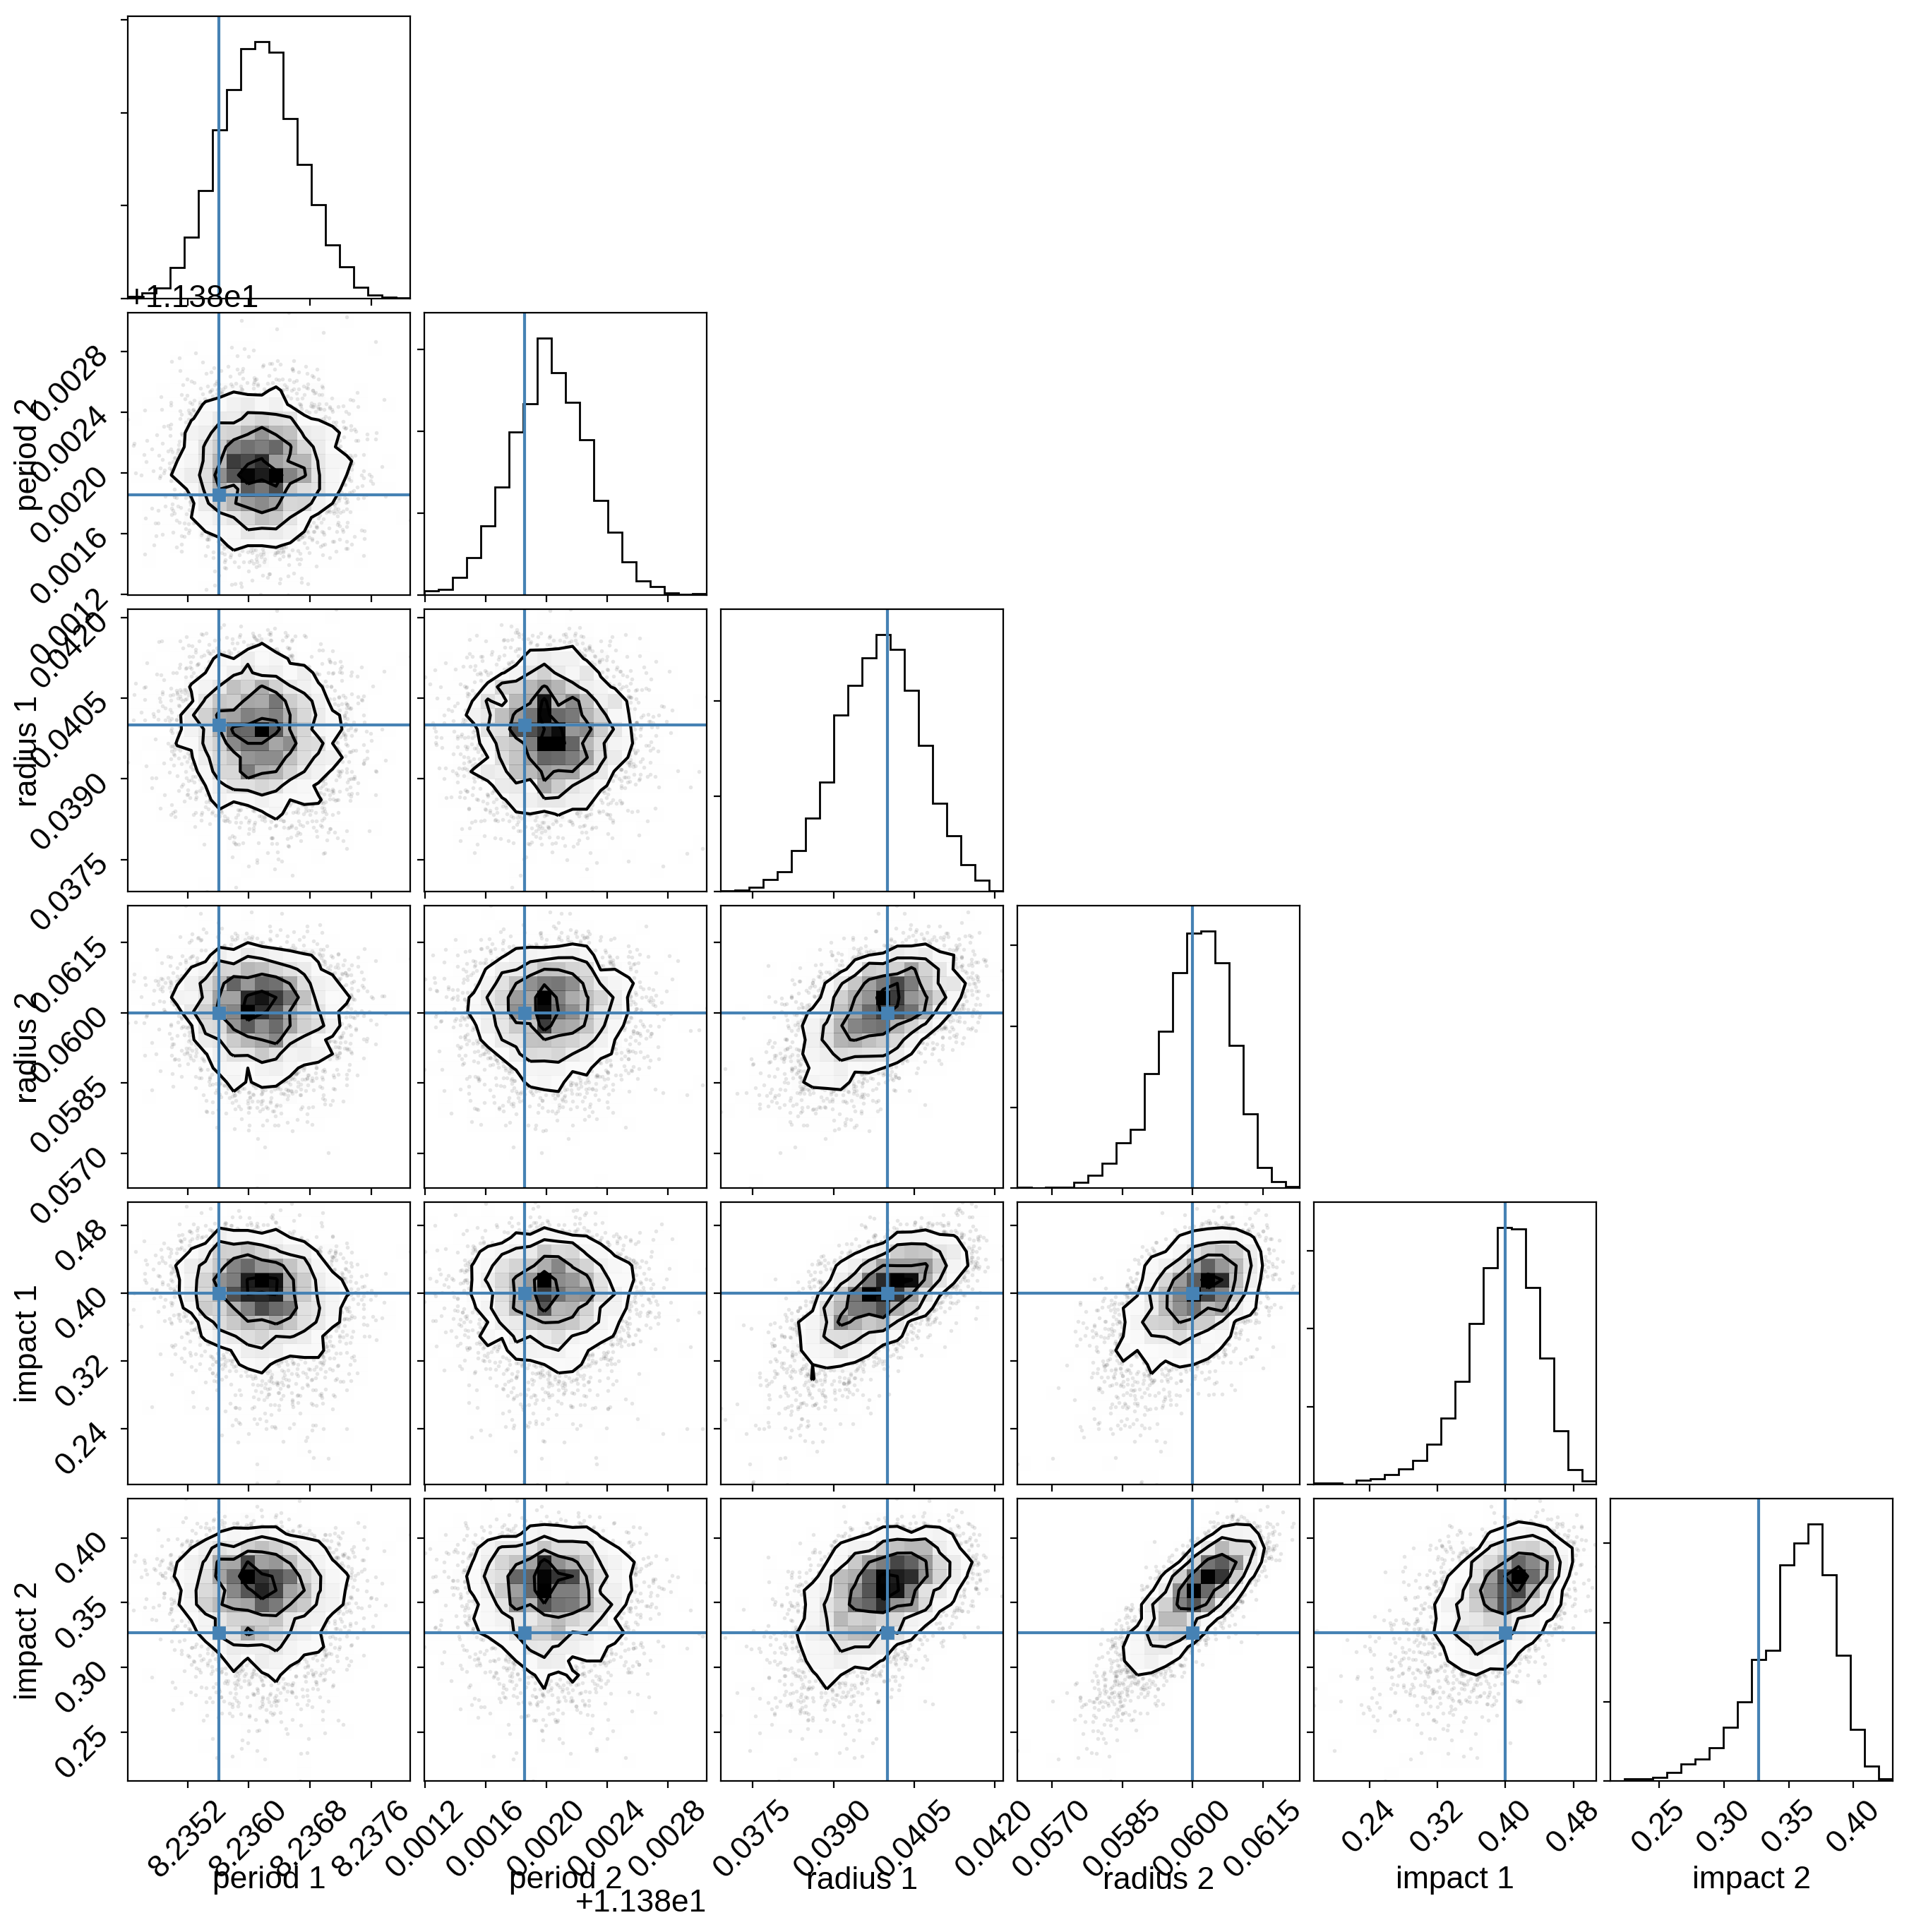

In [10]:
import corner

with model:
    truths = np.concatenate(
        list(map(np.atleast_1d, xo.eval_in_model([orbit.period, r, b])))
    )
samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "b"])
corner.corner(
    samples,
    truths=truths,
    labels=["period 1", "period 2", "radius 1", "radius 2", "impact 1", "impact 2"],
);

We could also plot corner plots of the transit times, but they're not terribly enlightening in this case so let's skip it.

Finally, let's plot the posterior estimates of the the transit times in an O-C diagram:

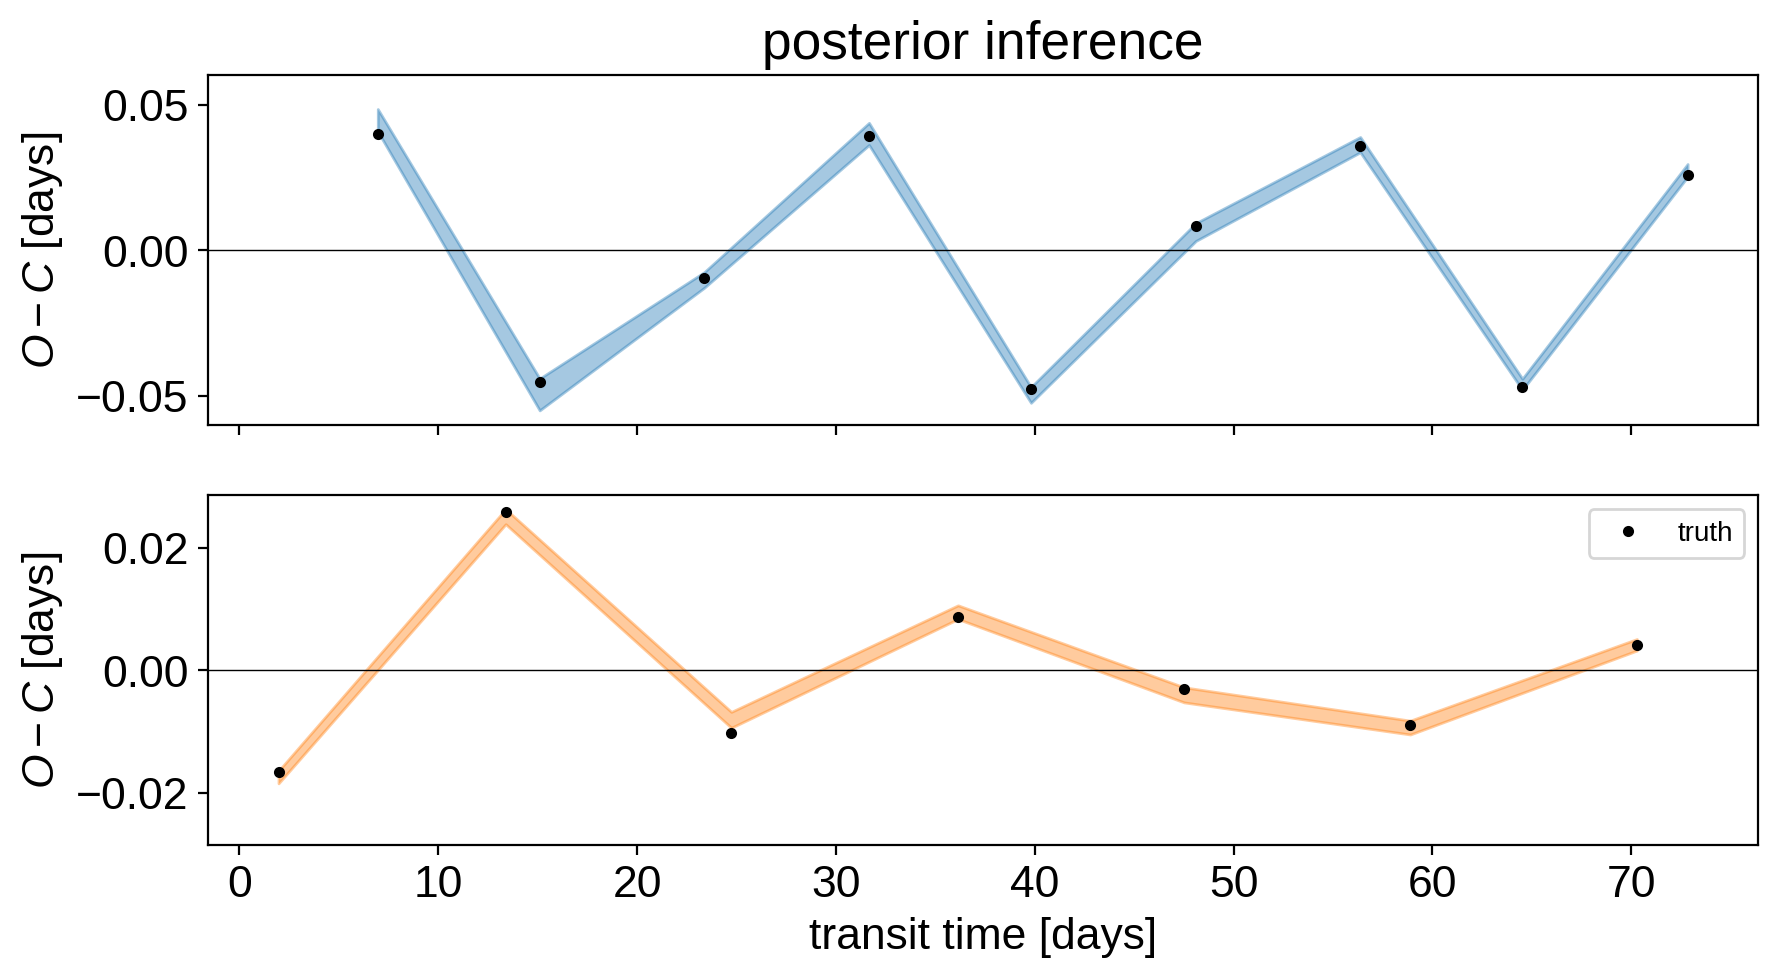

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

q = np.percentile(trace["ttvs_0"], [16, 50, 84], axis=0)
ax1.fill_between(
    np.mean(trace["tts_0"], axis=0), q[0], q[2], color="C0", alpha=0.4, edgecolor="none"
)
ref = np.polyval(
    np.polyfit(true_transit_times[0], true_ttvs[0], 1), true_transit_times[0]
)
ax1.plot(true_transit_times[0], true_ttvs[0] - ref, ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(trace["ttvs_1"], [16, 50, 84], axis=0)
ax2.fill_between(
    np.mean(trace["tts_1"], axis=0), q[0], q[2], color="C1", alpha=0.4, edgecolor="none"
)
ref = np.polyval(
    np.polyfit(true_transit_times[1], true_ttvs[1], 1), true_transit_times[1]
)
ax2.plot(true_transit_times[1], true_ttvs[1] - ref, ".k", label="truth")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))

ax2.legend(fontsize=10)
ax2.set_ylabel("$O-C$ [days]")
ax2.set_xlabel("transit time [days]")
ax1.set_title("posterior inference");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet},
   month = sep,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
